## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import pandas as pd
from openpyxl.utils import get_column_letter
from collections import OrderedDict
import json

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

## Parameters

In [2]:
BATCH_SIZE = 64
NUM_CLASSES = 3
LR = 1e-3
EPOCHS = 50
T = 10

SITE = 'B'
YEAR = 2020

np.random.seed(42)
torch.manual_seed(42)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using Device: {DEVICE}')

Using Device: cuda


## Data Loading

In [3]:
def load_data(*file_paths):
    """
    Returns:
        X (numpy.ndarray): Features array
        y (numpy.ndarray): Labels array
    """
    
    if len(file_paths) == 1:  # Single .npz file
        file_path = file_paths[0]
        
        if not file_path.endswith(".npz"):
            raise ValueError("Single input must be a .npz file")
            
        with np.load(file_path) as data:
            X = data["X"]
            y = data["y"]

    elif len(file_paths) == 2:  # Two .npy files
        x_path, y_path = file_paths
        
        if not (x_path.endswith(".npy") and y_path.endswith(".npy")):
            raise ValueError("When providing two inputs, both must be .npy files")
            
        X = np.load(x_path)
        y = np.load(y_path)

    return X, y

## Checking Distributions

In [4]:
def plot_input_dist(X):
    X_hist = X.reshape(-1, 6)  # shape: (N*T, 6)

    fig, axs = plt.subplots(2, 3, figsize=(15, 8))
    axs = axs.ravel()
    
    for i in range(6):
        axs[i].hist(X_hist[:, i], bins=50, color='steelblue', alpha=1)
        axs[i].set_title(f'Channel {i+1}')
    plt.tight_layout()
    plt.show()


def plot_label_dist(y):
    # Checking the label distribution of training data
    print('\n\n====== Label Distribution ======')
    unique_labels, counts = np.unique(y, return_counts=True)
    total = counts.sum()
    print(f"{'Label':<10}{'Count':<10}{'Percentage':<10}")
    print("-" * 30)
    for label, count in zip(unique_labels, counts):
        percentage = (count / total) * 100
        print(f"{label:<10}{count:<10}{percentage:<.2f}%")
    
    print(f"\nTotal samples: {total}")
    
    # Plot histogram for training data
    unique_labels, counts = np.unique(y, return_counts=True)
    plt.figure(figsize=(10, 4))
    plt.bar(unique_labels.astype(str), counts, color='skyblue', edgecolor='black')
    plt.xlabel("Labels")
    plt.ylabel("Count")
    plt.title(f"Label Distribution")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Input Preprocessing

In [5]:
def normalize(X):
    # Standardizing the input features across all timesteps and samples using Z-scores
    # Compute per-feature mean and std across all samples and timesteps
    feature_means = X.mean(axis=(0, 1))  # Shape: (6,)
    feature_stds = X.std(axis=(0, 1))    # Shape: (6,)
    
    # Reshape for broadcasting
    feature_means = feature_means.reshape(1, 1, -1)  # Shape: (1, 1, 6)
    feature_stds = feature_stds.reshape(1, 1, -1)    # Shape: (1, 1, 6)
    
    # Standardize
    X = ((X - feature_means) / feature_stds).astype(np.float32)
    return X

## Dataset Class

In [6]:
class Conv1dDataset(Dataset):
    def __init__(self, X, y):
        """
        X expected shape: (N, T, F)  -> convert to (N, C, L) with C=F, L=T
        Transpose to (N, F, T)
        """
        self.X = torch.tensor(X.transpose(0, 2, 1), dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return {"x": self.X[idx], "y": self.y[idx]}

## Model

In [7]:
def conv_block(in_channels: int, out_channels: int, dropout_p=0.3) -> nn.Module:
    return nn.Sequential(
        nn.Conv1d(in_channels, out_channels, 5,padding='same'),
        nn.BatchNorm1d(out_channels),
        nn.ReLU(),
        nn.Dropout(p=dropout_p)
    )

In [8]:
################ CNN Backbone
class cnn_dropout(nn.Module):
    def __init__(self, dropout_p=0.3):
        super().__init__()
        self.conv1 = conv_block(6, 64, dropout_p)
        self.conv2 = conv_block(64, 128, dropout_p)
        self.conv3 = conv_block(128, 256, dropout_p)
        self.conv4 = conv_block(256, 512, dropout_p)
        self.conv5 = conv_block(512, 1024, dropout_p)
        
        self.global_pool = nn.AdaptiveAvgPool1d(1)
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.global_pool(x)
        return x.view(x.size(0), -1)
 
 
################ Fully connected network
class FC_dropout(nn.Module):
    def __init__(self,input_dim, dropout_p=0.3):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout_p)
        self.fco = nn.Linear(input_dim, NUM_CLASSES)

    def forward(self, x):
        x = self.dropout(x)
        return self.fco(x)

In [9]:
# Loading model weights
backbone_state = torch.load('/kaggle/input/active-learning-subset/backboneSiteA2019.pth')
fc_state = torch.load('/kaggle/input/active-learning-subset/fcSiteA2019.pth')

backbone_state = OrderedDict((k.replace('module.', ''), v) for k, v in backbone_state.items())
fc_state = OrderedDict((k.replace('module.', ''), v) for k, v in fc_state.items())

In [10]:
# Enable dropout at inference/prediction (MC dropout)
def enable_dropout(model):
    """Enable dropout layers during test time."""
    for m in model.modules():
        if isinstance(m, nn.Dropout):
            m.train()  # Keep dropout in training mode

## Evaluation

In [11]:
def mc_dropout_eval(backbone, fc, dataloader, class_weights=None, T=T):
    backbone.eval()
    fc.eval()
    enable_dropout(backbone)
    enable_dropout(fc)

    all_preds = []
    all_labels = []
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"Validation"):
            x = batch["x"].to(DEVICE)
            y = batch["y"].to(DEVICE)
            all_labels.append(y.cpu())

            logits_T = []
            mc_outputs = []
            for _ in range(T):
                feat = backbone(x)
                logits = fc(feat)
                logits_T.append(logits)
                probs = F.softmax(logits, dim=1)  # (B, num_classes)
                mc_outputs.append(probs.unsqueeze(0))  # (1, B, C)

            # Stack and average: (T, B, C) → (B, C)
            logits_T = torch.stack(logits_T, dim=0)  # (T, B, C)
            mc_outputs = torch.cat(mc_outputs, dim=0)  # (T, B, C)
            mc_mean = mc_outputs.mean(dim=0)  # (B, C)

            # ===== Compute loss =====
            ce_t = [F.cross_entropy(l, y, weight=class_weights, reduction="mean") for l in logits_T]
            loss = torch.stack(ce_t).mean()
            batch_size = y.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size

            preds = torch.argmax(mc_mean, dim=1)
            all_preds.append(preds.cpu())

    # Concat all batches
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # ====== Metrics ======
    kappa = cohen_kappa_score(all_labels.numpy(), all_preds.numpy())
    acc = accuracy_score(all_labels.numpy(), all_preds.numpy())
    avg_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average="macro")
    per_class_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average=None)
    cm = confusion_matrix(all_labels.numpy(), all_preds.numpy())

    avg_loss = total_loss / total_samples

    return avg_loss, acc, avg_f1, per_class_f1, kappa, cm

## Training

In [12]:
def train(backbone, fc, train_loader, val_loader, device, class_weights=None, epochs=EPOCHS, T=T):
    backbone.train()
    fc.train()

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s, val_per_class_f1s, val_kappas = [], [], []

    optimizer = torch.optim.AdamW(list(backbone.parameters()) + list(fc.parameters()), lr=LR)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5)

    for epoch in range(epochs):
        backbone.train()
        fc.train()
        
        running_loss = 0.0
        correct = 0
        total_samples = 0
        
        for batch in train_loader:
            xt = batch["x"].to(device)
            yt = batch["y"].to(device)

            optimizer.zero_grad()

            features = backbone(xt)
            outputs = fc(features)
            loss = F.cross_entropy(outputs, yt, weight=class_weights)
            loss.backward()
            optimizer.step()

            batch_size = yt.size(0)
            running_loss += loss.item() * batch_size
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == yt).sum().item()
            total_samples += batch_size

        train_loss = running_loss / total_samples
        train_acc = correct / total_samples
        
        # Validation
        val_loss, val_acc, val_avg_f1, val_per_class_f1, val_kappa, _ = mc_dropout_eval(backbone, fc, val_loader, class_weights=class_weights, T=T)

        scheduler.step(val_loss)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        val_kappas.append(val_kappa)
        val_f1s.append(val_avg_f1)
        val_per_class_f1s.append(val_per_class_f1)
    
        print(f"Epoch [{epoch+1}/{EPOCHS}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, "
              f"F1: {val_avg_f1:.4f}, Kappa: {val_kappa:.4f}")  

    return train_losses, val_losses, train_accs, val_accs, val_kappas, val_f1s, val_per_class_f1s

## Plotting

In [13]:
def plot_loss_acc_f1s(train_losses, val_losses, train_accs, val_accs, val_f1s, EPOCHS=EPOCHS):
    epochs = range(1, EPOCHS + 1)

    plt.figure(figsize=(18, 5))  

    # --- Plot Loss ---
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Val Loss')
    plt.legend()
    plt.grid(True)

    # --- Plot Accuracy ---
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, val_accs, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train vs Val Accuracy')
    plt.legend()
    plt.grid(True)

    # --- Plot Validation F1 ---
    plt.subplot(1, 3, 3)
    plt.plot(epochs, val_f1s, label='Val F1', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('Validation F1 Score')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

## Saving Results

In [14]:
def save_results(output_file, history):
    # ensure .xlsx extension
    if not output_file.lower().endswith(".xlsx"):
        output_file = output_file + ".xlsx"

    with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
        for file_name, h in history.items():
            # ---------------------------
            # Per-epoch logs
            # ---------------------------
            df_epochs = pd.DataFrame({
                "epoch": list(range(1, len(h["train_loss"]) + 1)),
                "train_loss": h["train_loss"],
                "train_acc": h["train_acc"],
                "val_loss": h["val_loss"],
                "val_acc": h["val_acc"],
                "val_f1": h["val_f1s"],
                "val_kappa": h["val_kappas"],
                "val_per_class_f1": [
                    ",".join(map(str, f1s)) if f1s is not None else None 
                    for f1s in h["val_per_class_f1s"]
                ]
            })

            # ---------------------------
            # Final test metrics
            # ---------------------------
            final_metrics = {
                "metric": [
                    "overall_loss",
                    "overall_acc",
                    "kappa",
                    "avg_f1",
                    "per_class_f1",
                    "cm"
                ],
                "value": [
                    h["overall_loss"],
                    h["overall_acc"],
                    h["kappa"],
                    h["avg_f1"],
                    ",".join(map(str, h["per_class_f1"])) if h["per_class_f1"] is not None else None,
                    str(h["cm"]) if h["cm"] is not None else None
                ]
            }
            df_final = pd.DataFrame(final_metrics)

            # ---------------------------
            # Write to Excel
            # ---------------------------
            sheet_name = os.path.basename(file_name)[:31]  # Excel sheet name max length = 31
            df_epochs.to_excel(writer, sheet_name=sheet_name, index=False, startrow=0)
            startrow = len(df_epochs) + 2
            df_final.to_excel(writer, sheet_name=sheet_name, index=False, startrow=startrow)

        # ---------------------------
        # Auto-adjust column widths
        # ---------------------------
        for sheet_name, worksheet in writer.sheets.items():
            for col_idx, col_cells in enumerate(worksheet.columns, 1):
                max_length = 0
                col_letter = get_column_letter(col_idx)
                for cell in col_cells:
                    try:
                        if cell.value:
                            max_length = max(max_length, len(str(cell.value)))
                    except:
                        pass
                worksheet.column_dimensions[col_letter].width = max_length + 2

    print(f"Saved history of all files to {output_file}")

In [15]:
def save_history(history, name, output_dir="/kaggle/working"):
    def convert(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, (set, tuple)):
            return list(obj)
        return obj

    # Remove ".npz" if present
    base_name = os.path.basename(name).replace(".npz", "")
    output_file = os.path.join(output_dir, f"{base_name}_history.json")

    with open(output_file, "w") as f:
        json.dump(history, f, default=convert, indent=4)

    print(f'History Dumped in file {output_file}')

## Start

In [16]:
data_dir = "/kaggle/input/data-al"
file_names = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".npz")])
file_names = file_names[:4]

for name in file_names:
    print(name)

X_B2020_path = f'/kaggle/input/data-usa/Site_{SITE}/x-{YEAR}.npy'
y_B2020_path = f'/kaggle/input/data-usa/Site_{SITE}/y-{YEAR}.npy'

/kaggle/input/data-al/approx_BCNN_data_bald.npz
/kaggle/input/data-al/approx_BCNN_data_bvsb.npz
/kaggle/input/data-al/approx_BCNN_data_predictive_entropy.npz
/kaggle/input/data-al/approx_BCNN_data_variation_ratio.npz


In [17]:
history = {}

for name in file_names:
    history[name] = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [], 
        'val_acc': [],
        'val_f1s': [],
        'val_kappas': [],
        'val_per_class_f1s': [],
        
        'overall_loss': None,
        'overall_acc': None,
        'kappa': None,
        'avg_f1': None,
        'per_class_f1': None,
        'cm': None
    }



====== Loading Data /kaggle/input/data-al/approx_BCNN_data_bald.npz ======
Train Data:  (14000, 28, 6) (14000,)


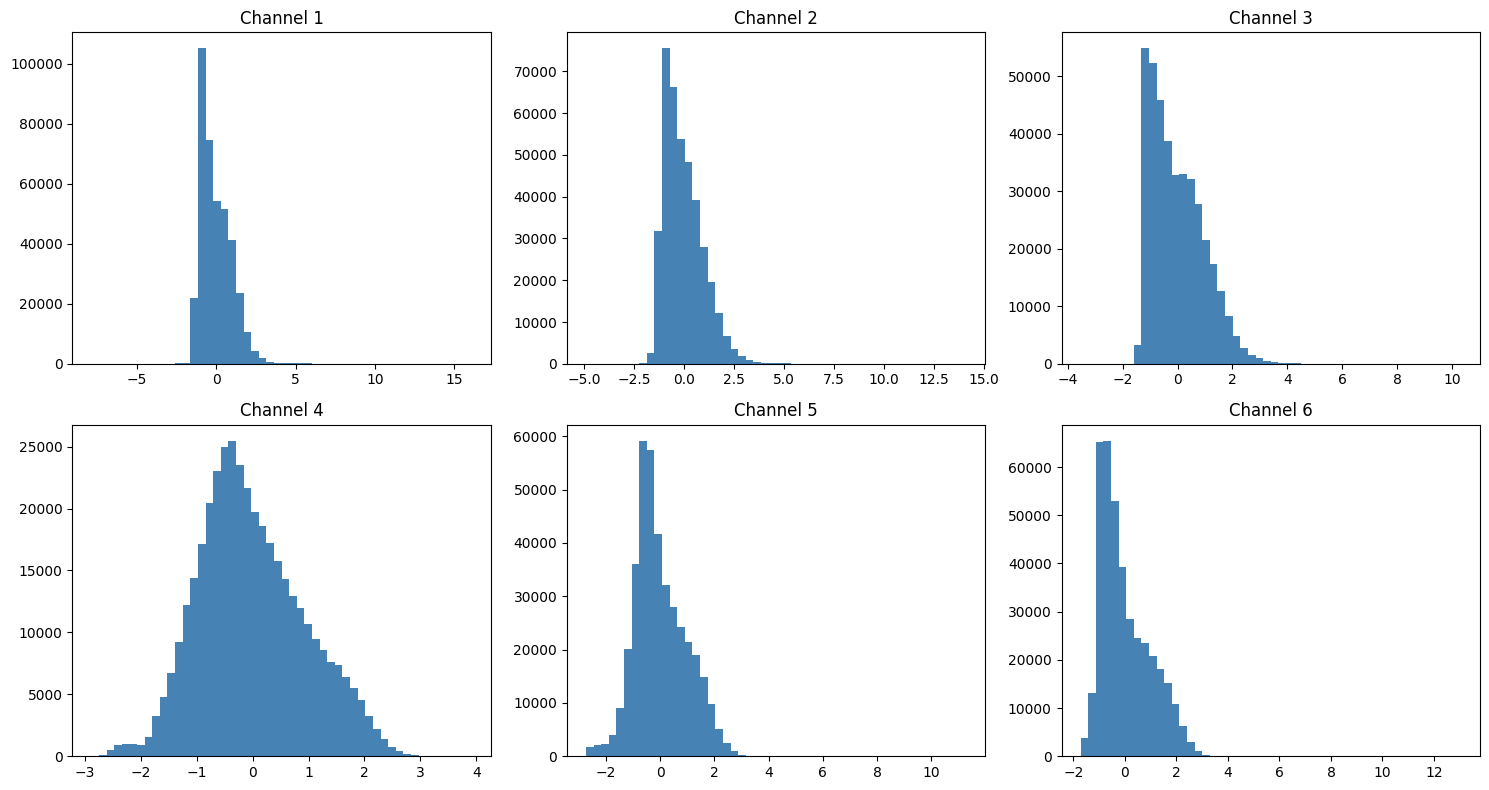

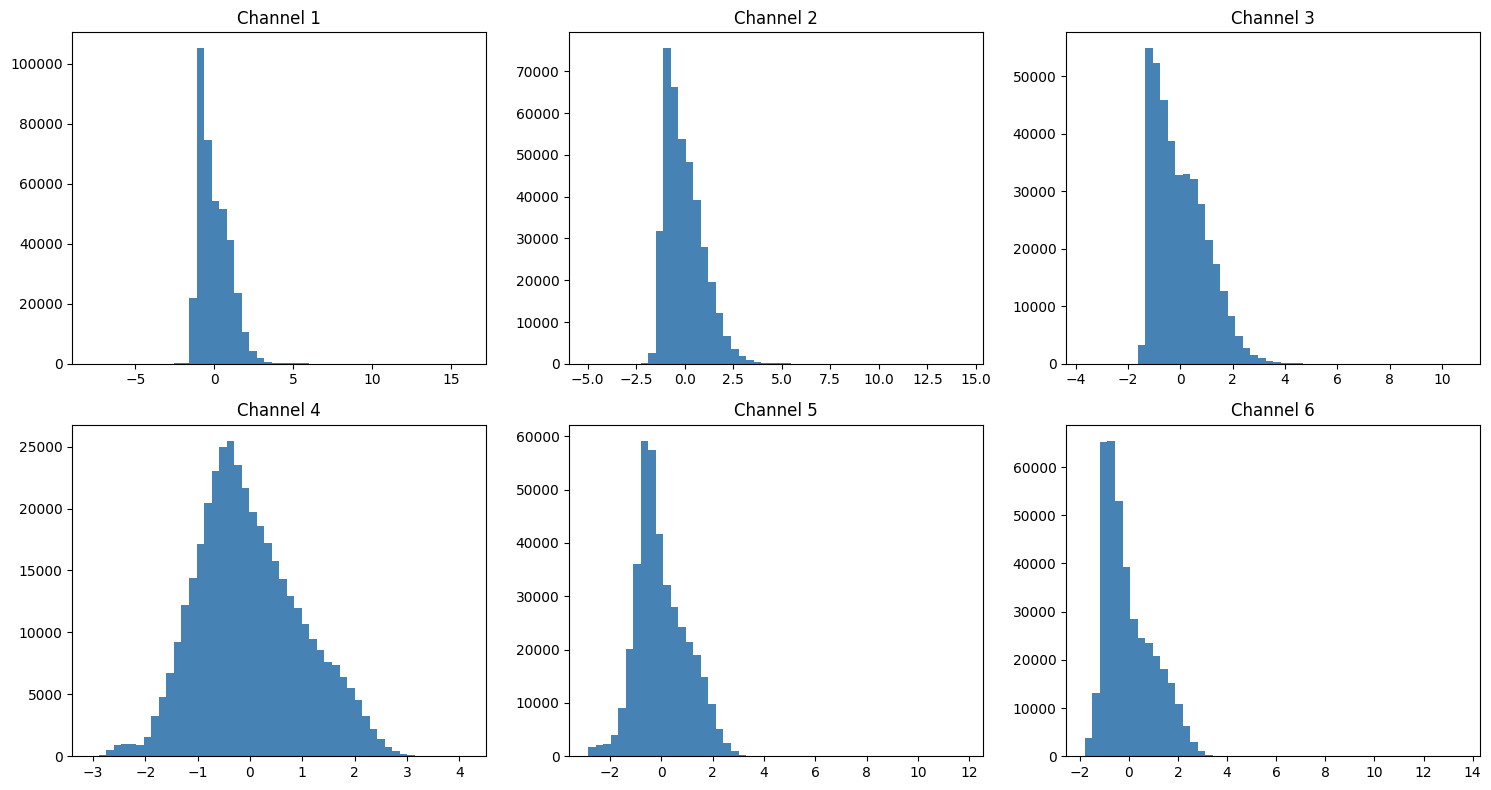



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         6333      45.24%
1         2121      15.15%
2         5546      39.61%

Total samples: 14000


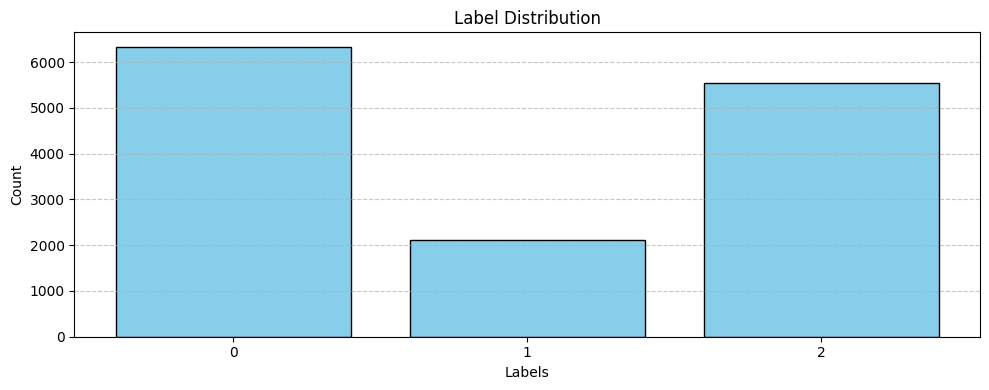


====== Loading Data Site B - 2020 ======
Site B - 2020 Data: (1943716, 28, 6), (1943716,)


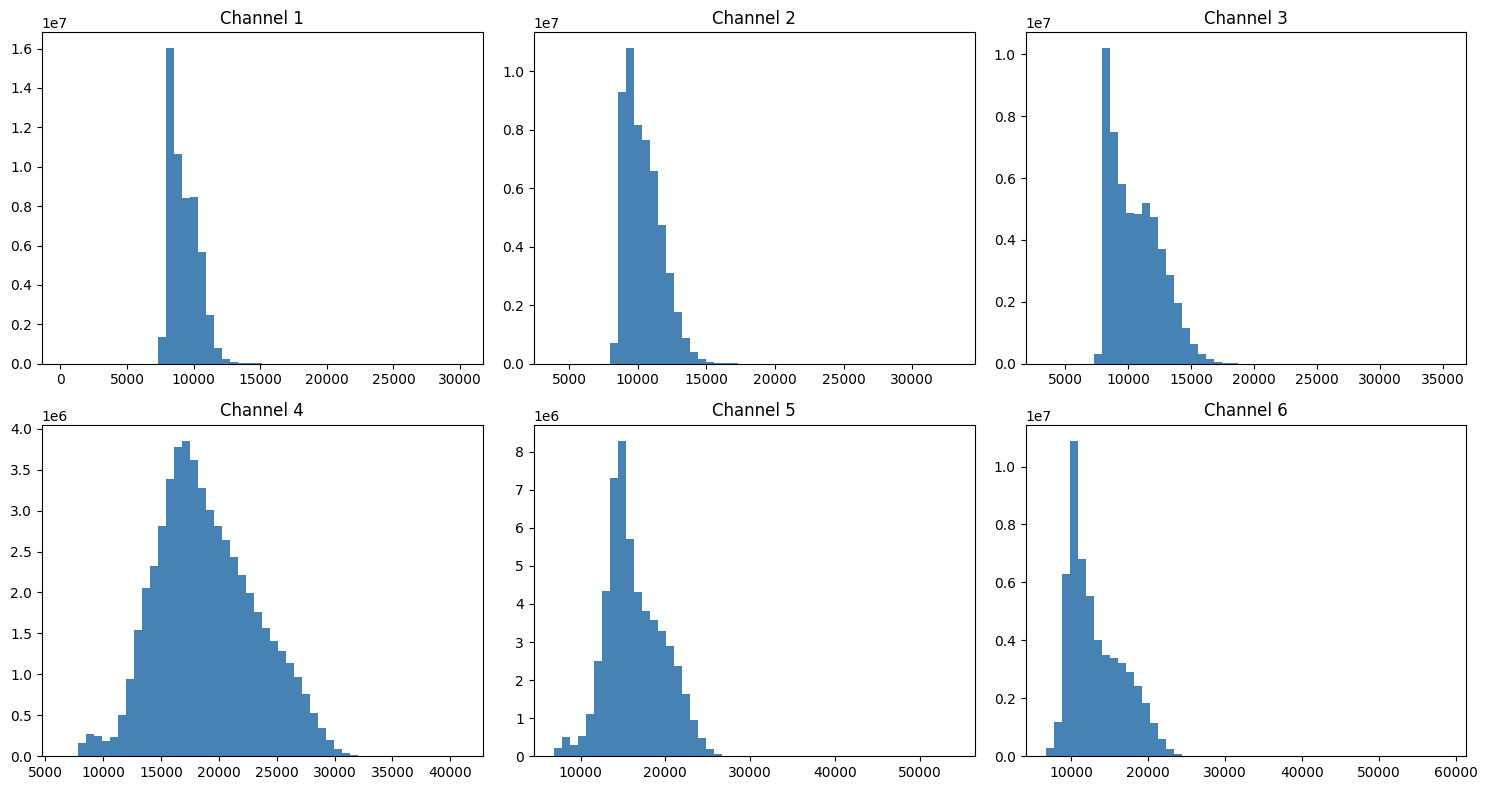

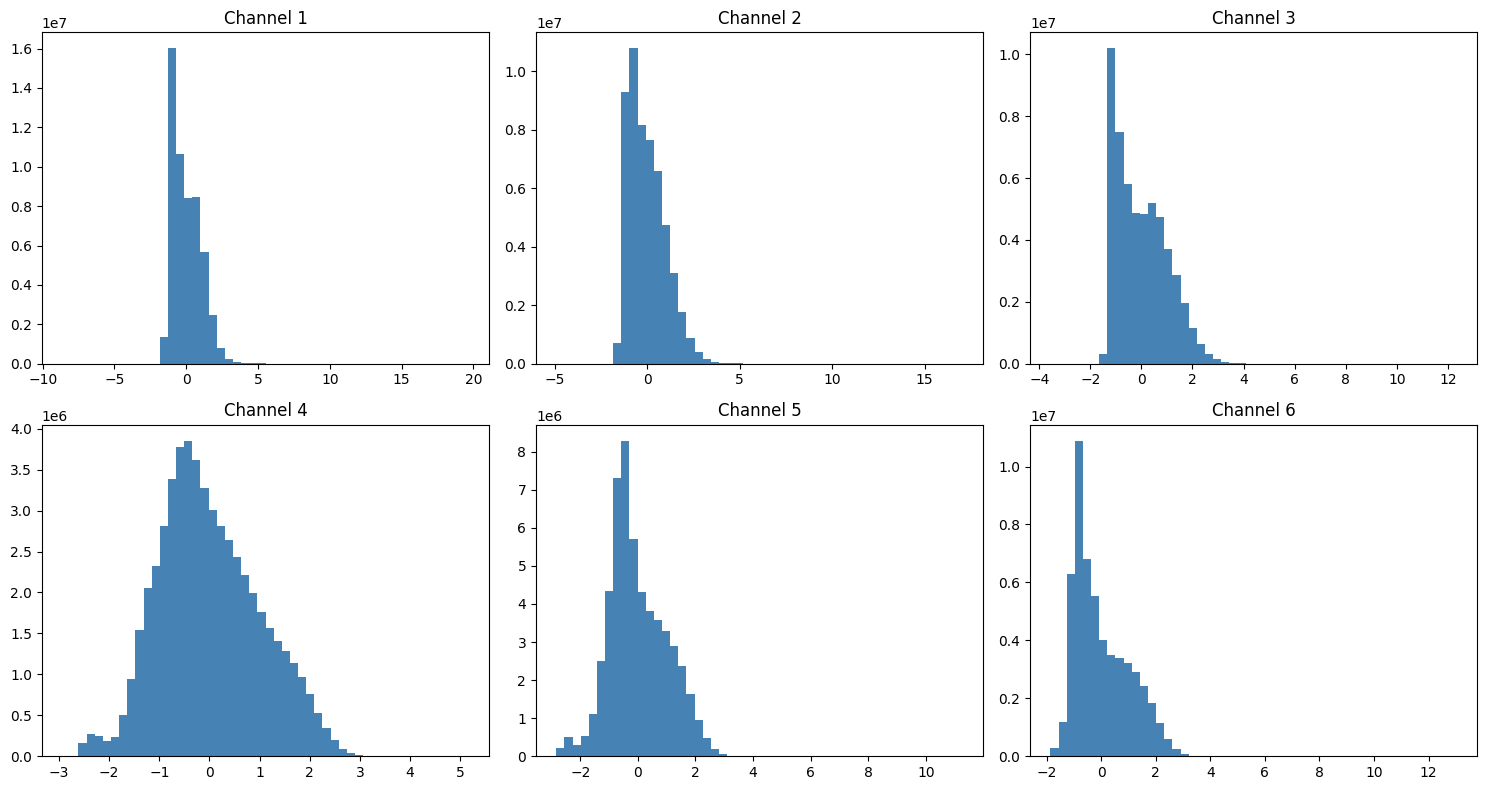



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         871034    44.81%
1         260775    13.42%
2         811907    41.77%

Total samples: 1943716


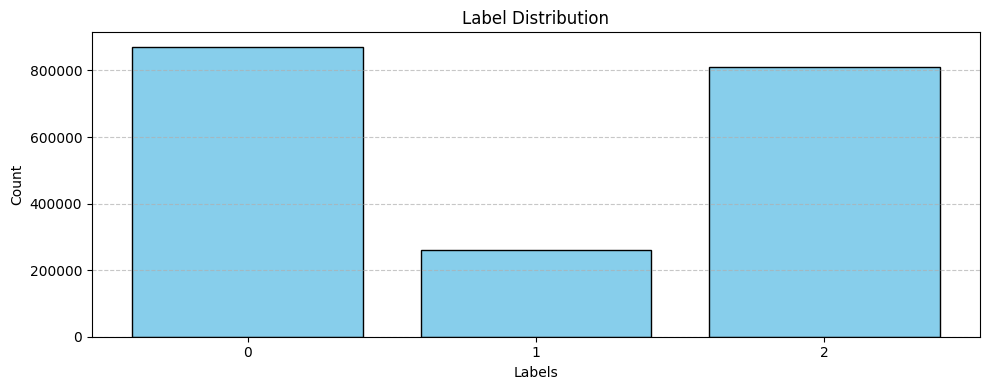

Val Data:  (9719, 28, 6) (9719,)
Test Data:  (1933997, 28, 6) (1933997,)
tensor([0.5521, 1.1632, 0.6106], device='cuda:0')

====== Training the Model ======


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.63it/s]


Epoch [1/50] Train Loss: 0.9913, Train Acc: 0.5874 | Val Loss: 0.4876, Val Acc: 0.8202, F1: 0.8273, Kappa: 0.7080


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.77it/s]


Epoch [2/50] Train Loss: 0.7591, Train Acc: 0.6467 | Val Loss: 0.4669, Val Acc: 0.7996, F1: 0.8058, Kappa: 0.6772


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.81it/s]


Epoch [3/50] Train Loss: 0.7102, Train Acc: 0.6726 | Val Loss: 0.3971, Val Acc: 0.8612, F1: 0.8638, Kappa: 0.7736


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.70it/s]


Epoch [4/50] Train Loss: 0.6801, Train Acc: 0.6848 | Val Loss: 0.3880, Val Acc: 0.8825, F1: 0.8858, Kappa: 0.8068


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.76it/s]


Epoch [5/50] Train Loss: 0.6622, Train Acc: 0.6976 | Val Loss: 0.3513, Val Acc: 0.8827, F1: 0.8845, Kappa: 0.8076


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.76it/s]


Epoch [6/50] Train Loss: 0.6397, Train Acc: 0.7077 | Val Loss: 0.3675, Val Acc: 0.8439, F1: 0.8452, Kappa: 0.7477


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.82it/s]


Epoch [7/50] Train Loss: 0.6277, Train Acc: 0.7077 | Val Loss: 0.3278, Val Acc: 0.8858, F1: 0.8857, Kappa: 0.8135


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.82it/s]


Epoch [8/50] Train Loss: 0.6127, Train Acc: 0.7201 | Val Loss: 0.3087, Val Acc: 0.8933, F1: 0.8917, Kappa: 0.8257


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.81it/s]


Epoch [9/50] Train Loss: 0.6005, Train Acc: 0.7264 | Val Loss: 0.3207, Val Acc: 0.8786, F1: 0.8858, Kappa: 0.8008


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.75it/s]


Epoch [10/50] Train Loss: 0.5979, Train Acc: 0.7255 | Val Loss: 0.3104, Val Acc: 0.8822, F1: 0.8817, Kappa: 0.8079


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.80it/s]


Epoch [11/50] Train Loss: 0.5823, Train Acc: 0.7337 | Val Loss: 0.3253, Val Acc: 0.8885, F1: 0.8919, Kappa: 0.8168


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.86it/s]


Epoch [12/50] Train Loss: 0.5773, Train Acc: 0.7381 | Val Loss: 0.2975, Val Acc: 0.8845, F1: 0.8835, Kappa: 0.8118


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.84it/s]


Epoch [13/50] Train Loss: 0.5705, Train Acc: 0.7428 | Val Loss: 0.2846, Val Acc: 0.8912, F1: 0.8914, Kappa: 0.8221


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.77it/s]


Epoch [14/50] Train Loss: 0.5631, Train Acc: 0.7435 | Val Loss: 0.3033, Val Acc: 0.8833, F1: 0.8855, Kappa: 0.8090


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.82it/s]


Epoch [15/50] Train Loss: 0.5536, Train Acc: 0.7505 | Val Loss: 0.2991, Val Acc: 0.8889, F1: 0.8880, Kappa: 0.8185


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.82it/s]


Epoch [16/50] Train Loss: 0.5502, Train Acc: 0.7528 | Val Loss: 0.2964, Val Acc: 0.8941, F1: 0.8929, Kappa: 0.8270


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.75it/s]


Epoch [17/50] Train Loss: 0.5481, Train Acc: 0.7544 | Val Loss: 0.2854, Val Acc: 0.8955, F1: 0.8960, Kappa: 0.8290


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.83it/s]


Epoch [18/50] Train Loss: 0.5394, Train Acc: 0.7562 | Val Loss: 0.2679, Val Acc: 0.9035, F1: 0.9050, Kappa: 0.8415


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.81it/s]


Epoch [19/50] Train Loss: 0.5344, Train Acc: 0.7631 | Val Loss: 0.3518, Val Acc: 0.8533, F1: 0.8635, Kappa: 0.7601


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.79it/s]


Epoch [20/50] Train Loss: 0.5304, Train Acc: 0.7623 | Val Loss: 0.2670, Val Acc: 0.8970, F1: 0.8969, Kappa: 0.8314


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.83it/s]


Epoch [21/50] Train Loss: 0.5279, Train Acc: 0.7663 | Val Loss: 0.2856, Val Acc: 0.8981, F1: 0.9032, Kappa: 0.8320


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.85it/s]


Epoch [22/50] Train Loss: 0.5118, Train Acc: 0.7732 | Val Loss: 0.2680, Val Acc: 0.9006, F1: 0.9015, Kappa: 0.8371


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.75it/s]


Epoch [23/50] Train Loss: 0.5183, Train Acc: 0.7656 | Val Loss: 0.2914, Val Acc: 0.8860, F1: 0.8891, Kappa: 0.8139


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.79it/s]


Epoch [24/50] Train Loss: 0.5089, Train Acc: 0.7750 | Val Loss: 0.2788, Val Acc: 0.8981, F1: 0.8997, Kappa: 0.8330


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.79it/s]


Epoch [25/50] Train Loss: 0.5087, Train Acc: 0.7745 | Val Loss: 0.2775, Val Acc: 0.8970, F1: 0.9006, Kappa: 0.8306


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.80it/s]


Epoch [26/50] Train Loss: 0.4965, Train Acc: 0.7793 | Val Loss: 0.3419, Val Acc: 0.8561, F1: 0.8638, Kappa: 0.7652


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.82it/s]


Epoch [27/50] Train Loss: 0.4683, Train Acc: 0.7959 | Val Loss: 0.2629, Val Acc: 0.9000, F1: 0.9008, Kappa: 0.8360


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.80it/s]


Epoch [28/50] Train Loss: 0.4572, Train Acc: 0.7948 | Val Loss: 0.2573, Val Acc: 0.9056, F1: 0.9072, Kappa: 0.8451


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.87it/s]


Epoch [29/50] Train Loss: 0.4535, Train Acc: 0.7999 | Val Loss: 0.2768, Val Acc: 0.8867, F1: 0.8902, Kappa: 0.8148


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.64it/s]


Epoch [30/50] Train Loss: 0.4583, Train Acc: 0.7973 | Val Loss: 0.2579, Val Acc: 0.9073, F1: 0.9102, Kappa: 0.8476


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.71it/s]


Epoch [31/50] Train Loss: 0.4529, Train Acc: 0.8011 | Val Loss: 0.2649, Val Acc: 0.9064, F1: 0.9095, Kappa: 0.8459


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.75it/s]


Epoch [32/50] Train Loss: 0.4363, Train Acc: 0.8091 | Val Loss: 0.2603, Val Acc: 0.9009, F1: 0.9018, Kappa: 0.8377


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.56it/s]


Epoch [33/50] Train Loss: 0.4390, Train Acc: 0.8072 | Val Loss: 0.2541, Val Acc: 0.9048, F1: 0.9067, Kappa: 0.8437


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.51it/s]


Epoch [34/50] Train Loss: 0.4345, Train Acc: 0.8111 | Val Loss: 0.2567, Val Acc: 0.9063, F1: 0.9074, Kappa: 0.8462


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.73it/s]


Epoch [35/50] Train Loss: 0.4359, Train Acc: 0.8094 | Val Loss: 0.2571, Val Acc: 0.9040, F1: 0.9074, Kappa: 0.8422


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.71it/s]


Epoch [36/50] Train Loss: 0.4316, Train Acc: 0.8084 | Val Loss: 0.2573, Val Acc: 0.9040, F1: 0.9047, Kappa: 0.8424


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.69it/s]


Epoch [37/50] Train Loss: 0.4299, Train Acc: 0.8099 | Val Loss: 0.2562, Val Acc: 0.9036, F1: 0.9048, Kappa: 0.8419


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.66it/s]


Epoch [38/50] Train Loss: 0.4301, Train Acc: 0.8111 | Val Loss: 0.2659, Val Acc: 0.8992, F1: 0.9023, Kappa: 0.8343


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.47it/s]


Epoch [39/50] Train Loss: 0.4131, Train Acc: 0.8175 | Val Loss: 0.2849, Val Acc: 0.8989, F1: 0.9011, Kappa: 0.8338


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.73it/s]


Epoch [40/50] Train Loss: 0.3883, Train Acc: 0.8297 | Val Loss: 0.2559, Val Acc: 0.9089, F1: 0.9103, Kappa: 0.8504


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.80it/s]


Epoch [41/50] Train Loss: 0.3906, Train Acc: 0.8271 | Val Loss: 0.2564, Val Acc: 0.9113, F1: 0.9129, Kappa: 0.8541


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.76it/s]


Epoch [42/50] Train Loss: 0.3856, Train Acc: 0.8360 | Val Loss: 0.2625, Val Acc: 0.9082, F1: 0.9092, Kappa: 0.8493


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.74it/s]


Epoch [43/50] Train Loss: 0.3823, Train Acc: 0.8324 | Val Loss: 0.2559, Val Acc: 0.9113, F1: 0.9129, Kappa: 0.8541


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.76it/s]


Epoch [44/50] Train Loss: 0.3811, Train Acc: 0.8334 | Val Loss: 0.2586, Val Acc: 0.9060, F1: 0.9058, Kappa: 0.8458


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.77it/s]


Epoch [45/50] Train Loss: 0.3702, Train Acc: 0.8391 | Val Loss: 0.2621, Val Acc: 0.9061, F1: 0.9077, Kappa: 0.8457


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.74it/s]


Epoch [46/50] Train Loss: 0.3662, Train Acc: 0.8451 | Val Loss: 0.2626, Val Acc: 0.9048, F1: 0.9066, Kappa: 0.8438


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.75it/s]


Epoch [47/50] Train Loss: 0.3604, Train Acc: 0.8451 | Val Loss: 0.2649, Val Acc: 0.9094, F1: 0.9104, Kappa: 0.8510


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.81it/s]


Epoch [48/50] Train Loss: 0.3509, Train Acc: 0.8488 | Val Loss: 0.2660, Val Acc: 0.9101, F1: 0.9117, Kappa: 0.8522


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.72it/s]


Epoch [49/50] Train Loss: 0.3481, Train Acc: 0.8467 | Val Loss: 0.2648, Val Acc: 0.9076, F1: 0.9080, Kappa: 0.8483


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.74it/s]


Epoch [50/50] Train Loss: 0.3553, Train Acc: 0.8464 | Val Loss: 0.2656, Val Acc: 0.9095, F1: 0.9106, Kappa: 0.8512


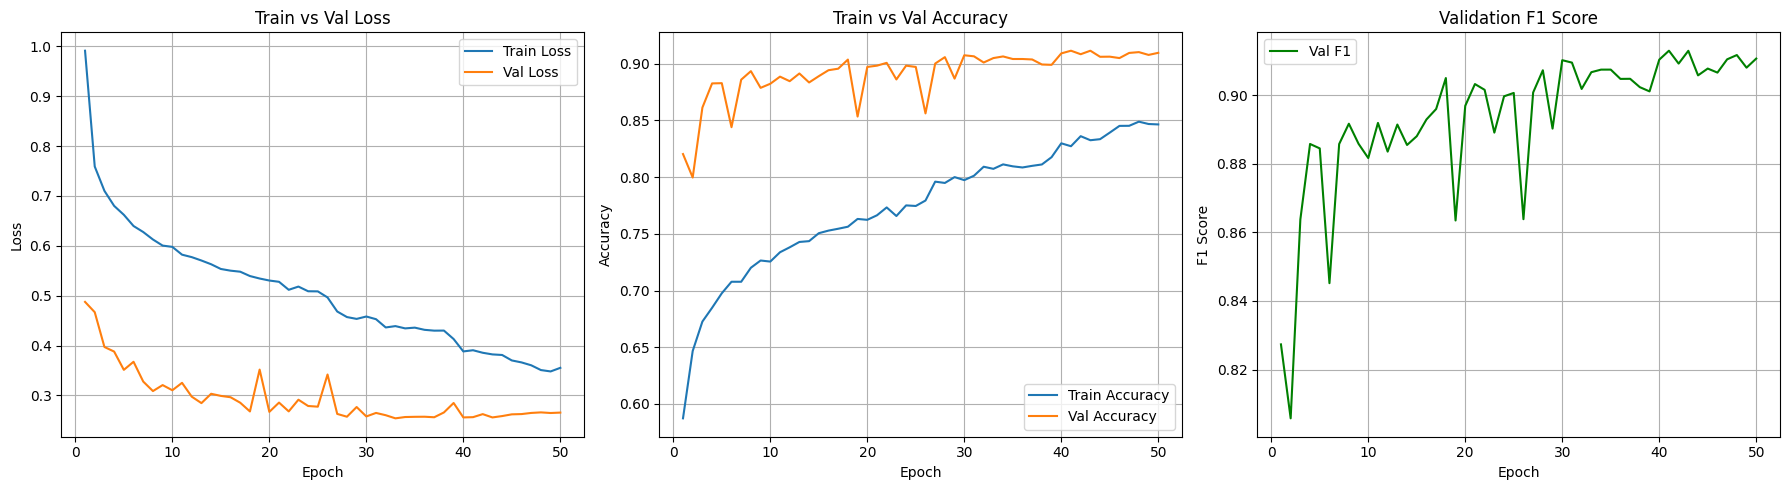


====== Testing the Model ======


Validation: 100%|██████████| 30219/30219 [12:46<00:00, 39.41it/s]



====== Test Results ======
Overall Loss: 0.2605
Overall Accuracy: 0.9107
Cohen's Kappa: 0.8531
Per Class F1: [0.91016888 0.9208814  0.90794749]
Macro (Avg) F1: 0.9130


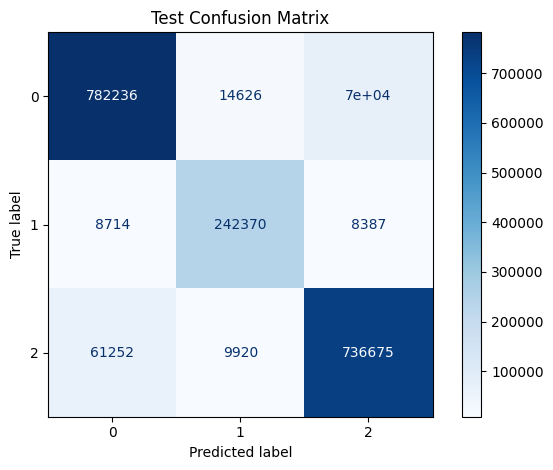

History Dumped in file /kaggle/working/approx_BCNN_data_bald_history.json_history.json


====== Loading Data /kaggle/input/data-al/approx_BCNN_data_bvsb.npz ======
Train Data:  (14000, 28, 6) (14000,)


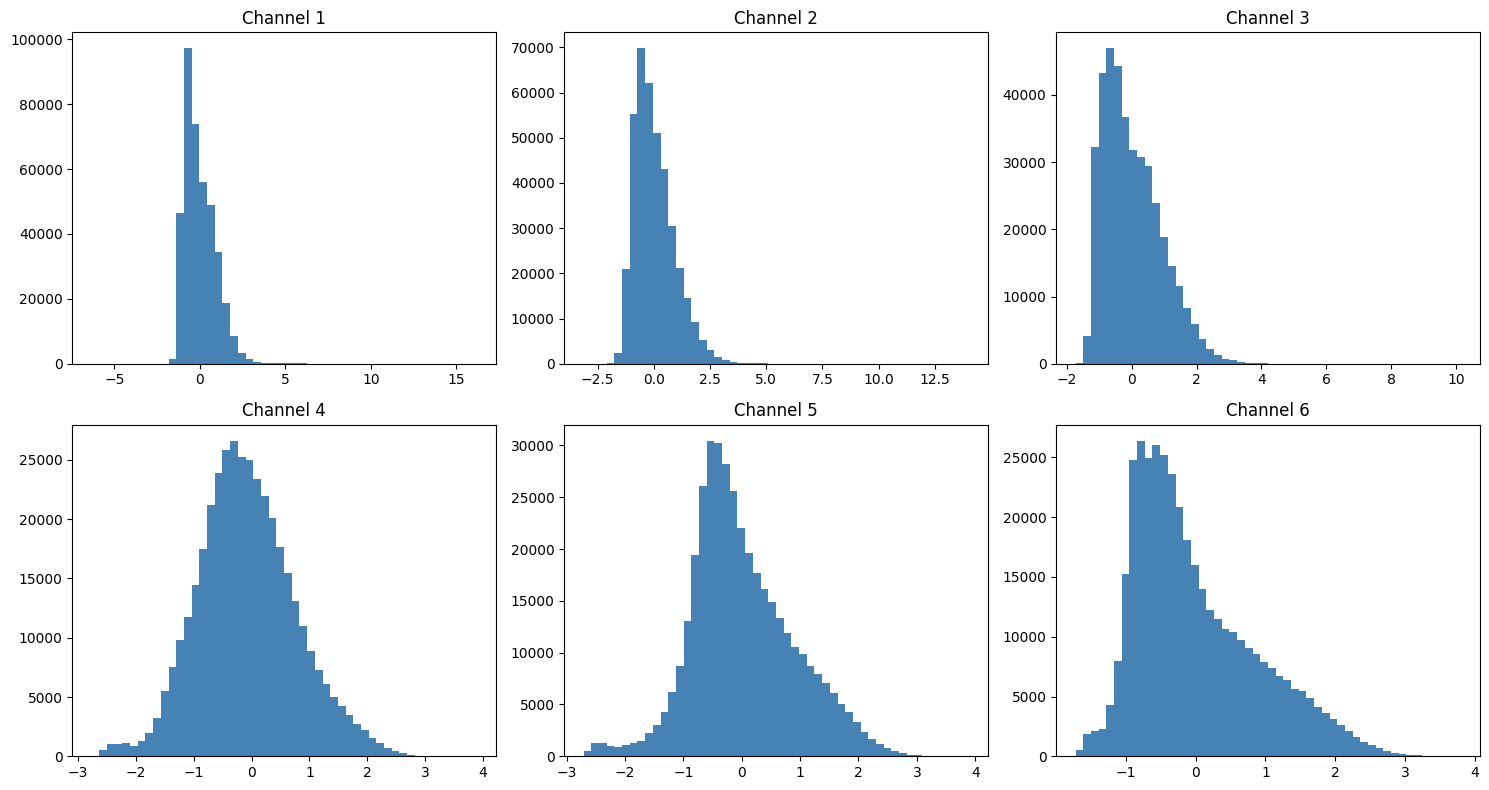

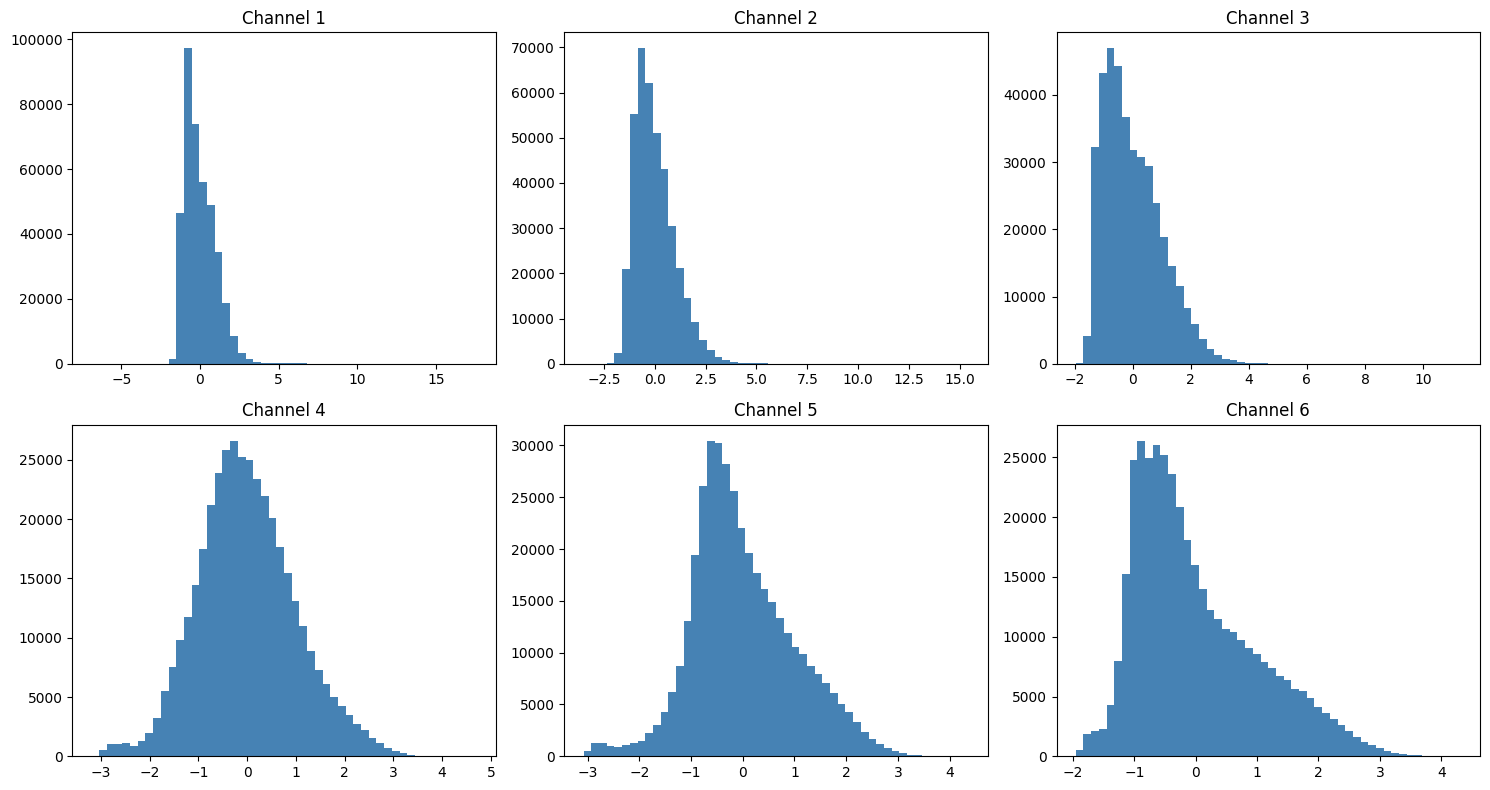



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         6332      45.23%
1         1601      11.44%
2         6067      43.34%

Total samples: 14000


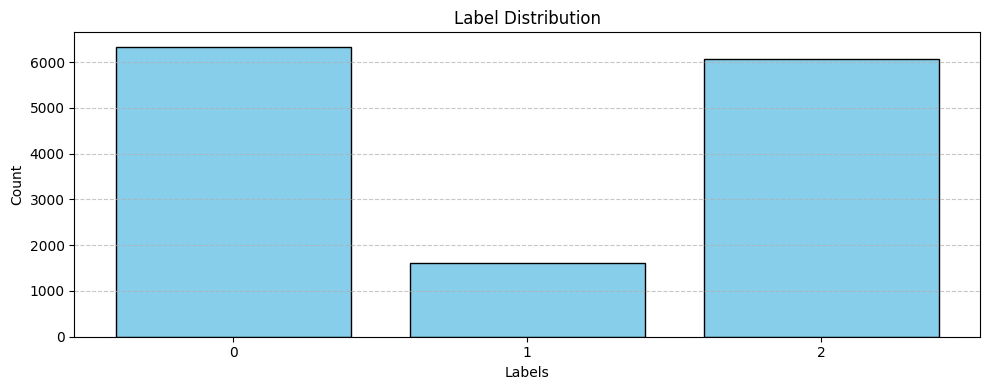


====== Loading Data Site B - 2020 ======
Site B - 2020 Data: (1943716, 28, 6), (1943716,)


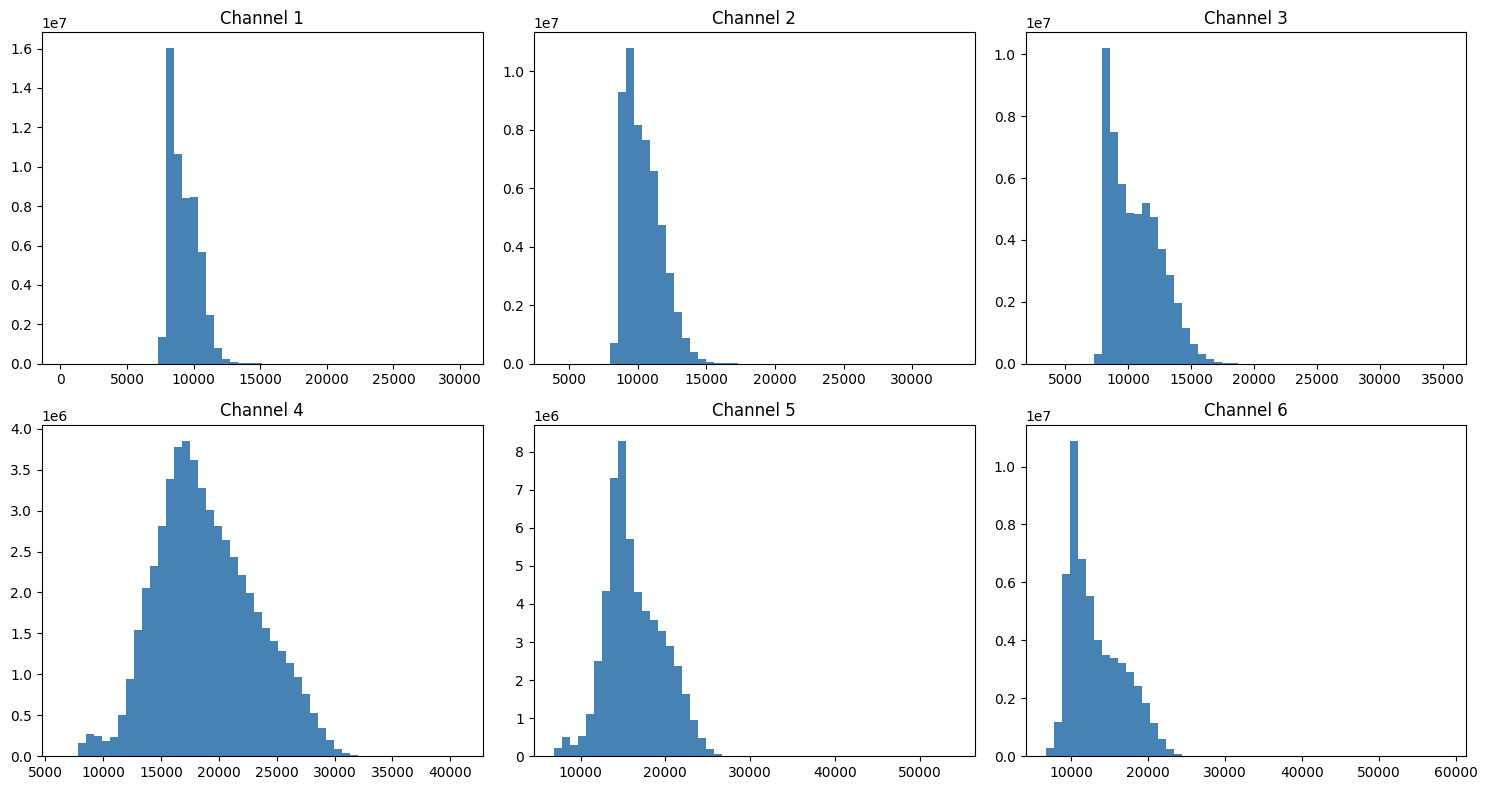

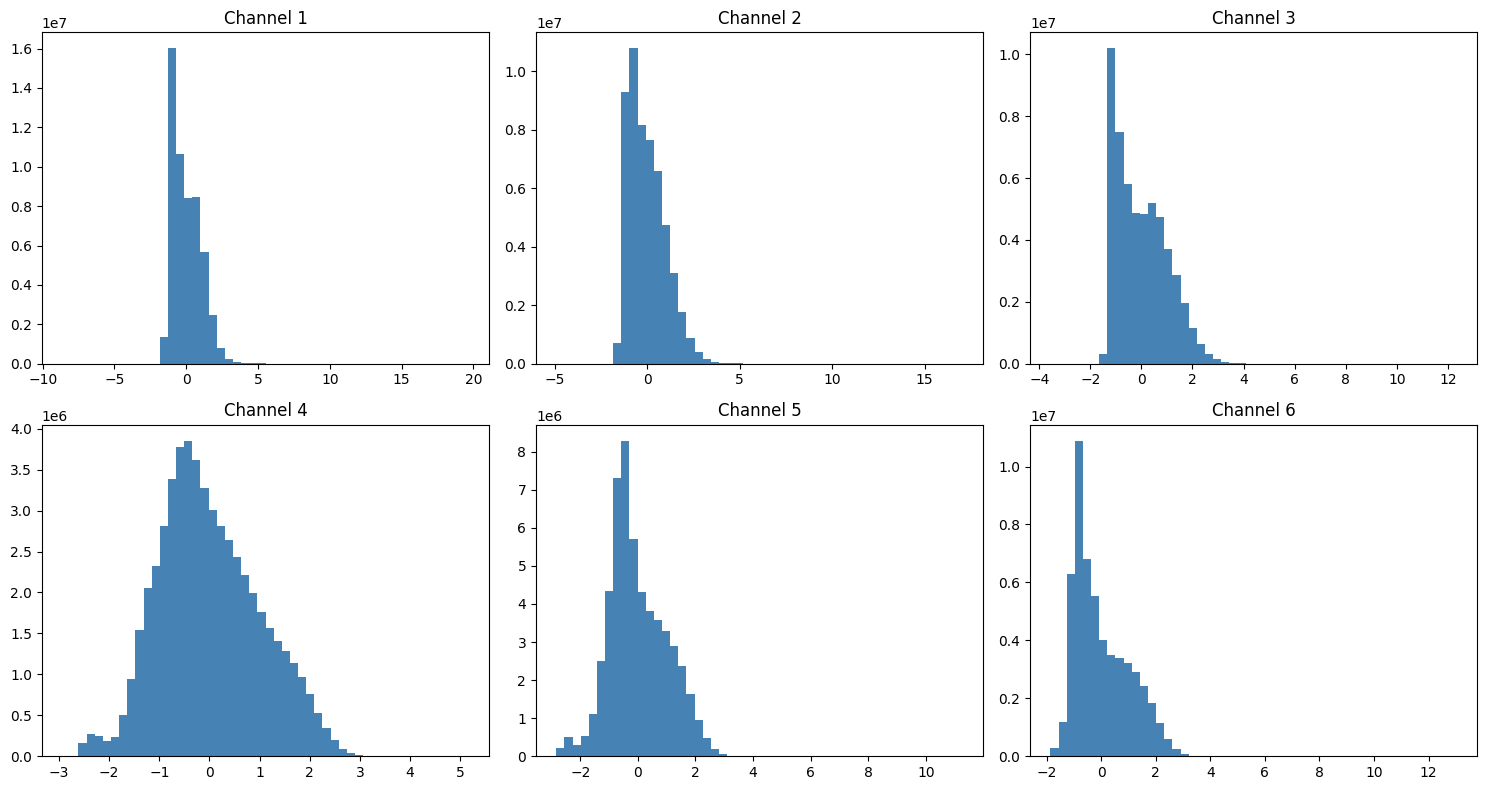



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         871034    44.81%
1         260775    13.42%
2         811907    41.77%

Total samples: 1943716


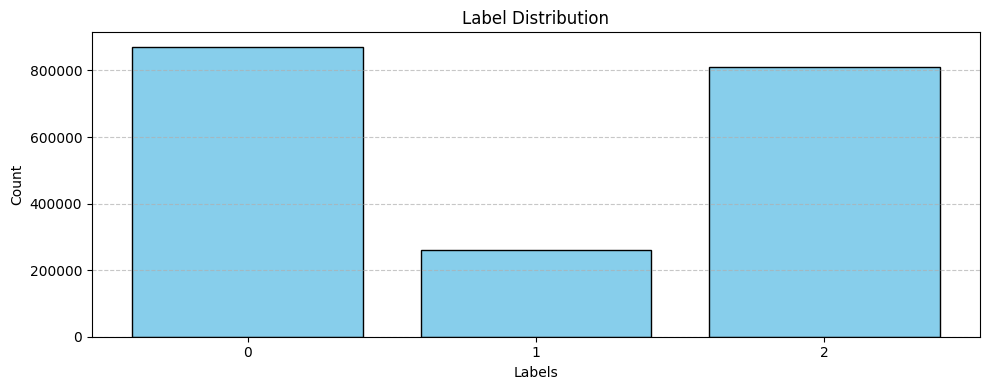

Val Data:  (9719, 28, 6) (9719,)
Test Data:  (1933997, 28, 6) (1933997,)
tensor([0.5522, 1.3648, 0.5705], device='cuda:0')

====== Training the Model ======


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.72it/s]


Epoch [1/50] Train Loss: 1.1163, Train Acc: 0.5414 | Val Loss: 0.5744, Val Acc: 0.8069, F1: 0.8144, Kappa: 0.6855


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.73it/s]


Epoch [2/50] Train Loss: 0.8453, Train Acc: 0.5879 | Val Loss: 0.5355, Val Acc: 0.7978, F1: 0.8047, Kappa: 0.6712


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.68it/s]


Epoch [3/50] Train Loss: 0.7899, Train Acc: 0.6147 | Val Loss: 0.4563, Val Acc: 0.8034, F1: 0.8182, Kappa: 0.6803


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.73it/s]


Epoch [4/50] Train Loss: 0.7599, Train Acc: 0.6186 | Val Loss: 0.4174, Val Acc: 0.8321, F1: 0.8278, Kappa: 0.7307


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.68it/s]


Epoch [5/50] Train Loss: 0.7378, Train Acc: 0.6280 | Val Loss: 0.4837, Val Acc: 0.8615, F1: 0.8635, Kappa: 0.7696


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.69it/s]


Epoch [6/50] Train Loss: 0.7274, Train Acc: 0.6373 | Val Loss: 0.4105, Val Acc: 0.8446, F1: 0.8374, Kappa: 0.7502


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.73it/s]


Epoch [7/50] Train Loss: 0.7269, Train Acc: 0.6372 | Val Loss: 0.4524, Val Acc: 0.8162, F1: 0.8280, Kappa: 0.6972


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.72it/s]


Epoch [8/50] Train Loss: 0.7098, Train Acc: 0.6417 | Val Loss: 0.4190, Val Acc: 0.8637, F1: 0.8669, Kappa: 0.7769


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.65it/s]


Epoch [9/50] Train Loss: 0.7040, Train Acc: 0.6461 | Val Loss: 0.3691, Val Acc: 0.8785, F1: 0.8767, Kappa: 0.8015


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.74it/s]


Epoch [10/50] Train Loss: 0.6986, Train Acc: 0.6561 | Val Loss: 0.3298, Val Acc: 0.8834, F1: 0.8826, Kappa: 0.8097


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.72it/s]


Epoch [11/50] Train Loss: 0.6960, Train Acc: 0.6515 | Val Loss: 0.3471, Val Acc: 0.8848, F1: 0.8829, Kappa: 0.8117


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.70it/s]


Epoch [12/50] Train Loss: 0.6875, Train Acc: 0.6551 | Val Loss: 0.3419, Val Acc: 0.8786, F1: 0.8774, Kappa: 0.8023


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.74it/s]


Epoch [13/50] Train Loss: 0.6879, Train Acc: 0.6606 | Val Loss: 0.3608, Val Acc: 0.8601, F1: 0.8572, Kappa: 0.7731


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.75it/s]


Epoch [14/50] Train Loss: 0.6819, Train Acc: 0.6612 | Val Loss: 0.4159, Val Acc: 0.8406, F1: 0.8483, Kappa: 0.7389


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.70it/s]


Epoch [15/50] Train Loss: 0.6789, Train Acc: 0.6614 | Val Loss: 0.3477, Val Acc: 0.8891, F1: 0.8912, Kappa: 0.8178


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.75it/s]


Epoch [16/50] Train Loss: 0.6729, Train Acc: 0.6689 | Val Loss: 0.3196, Val Acc: 0.8972, F1: 0.8966, Kappa: 0.8312


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.76it/s]


Epoch [17/50] Train Loss: 0.6668, Train Acc: 0.6704 | Val Loss: 0.3714, Val Acc: 0.8712, F1: 0.8754, Kappa: 0.7888


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.78it/s]


Epoch [18/50] Train Loss: 0.6742, Train Acc: 0.6679 | Val Loss: 0.4062, Val Acc: 0.8614, F1: 0.8690, Kappa: 0.7713


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.71it/s]


Epoch [19/50] Train Loss: 0.6619, Train Acc: 0.6732 | Val Loss: 0.3220, Val Acc: 0.8920, F1: 0.8928, Kappa: 0.8228


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.77it/s]


Epoch [20/50] Train Loss: 0.6511, Train Acc: 0.6790 | Val Loss: 0.2857, Val Acc: 0.9000, F1: 0.8992, Kappa: 0.8361


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.77it/s]


Epoch [21/50] Train Loss: 0.6409, Train Acc: 0.6862 | Val Loss: 0.3122, Val Acc: 0.8894, F1: 0.8861, Kappa: 0.8197


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.75it/s]


Epoch [22/50] Train Loss: 0.6444, Train Acc: 0.6817 | Val Loss: 0.4052, Val Acc: 0.8458, F1: 0.8541, Kappa: 0.7459


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.72it/s]


Epoch [23/50] Train Loss: 0.6424, Train Acc: 0.6827 | Val Loss: 0.3630, Val Acc: 0.8635, F1: 0.8683, Kappa: 0.7766


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.73it/s]


Epoch [24/50] Train Loss: 0.6374, Train Acc: 0.6858 | Val Loss: 0.2991, Val Acc: 0.8973, F1: 0.8965, Kappa: 0.8316


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.69it/s]


Epoch [25/50] Train Loss: 0.6357, Train Acc: 0.6901 | Val Loss: 0.3327, Val Acc: 0.8954, F1: 0.8987, Kappa: 0.8276


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.74it/s]


Epoch [26/50] Train Loss: 0.6243, Train Acc: 0.6955 | Val Loss: 0.3192, Val Acc: 0.8722, F1: 0.8737, Kappa: 0.7921


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.72it/s]


Epoch [27/50] Train Loss: 0.5991, Train Acc: 0.7058 | Val Loss: 0.2979, Val Acc: 0.9091, F1: 0.9101, Kappa: 0.8502


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.73it/s]


Epoch [28/50] Train Loss: 0.5917, Train Acc: 0.7141 | Val Loss: 0.3003, Val Acc: 0.9024, F1: 0.9018, Kappa: 0.8400


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.68it/s]


Epoch [29/50] Train Loss: 0.5946, Train Acc: 0.7060 | Val Loss: 0.2851, Val Acc: 0.9019, F1: 0.9012, Kappa: 0.8394


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.75it/s]


Epoch [30/50] Train Loss: 0.5862, Train Acc: 0.7126 | Val Loss: 0.2814, Val Acc: 0.9037, F1: 0.9043, Kappa: 0.8415


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.71it/s]


Epoch [31/50] Train Loss: 0.5838, Train Acc: 0.7169 | Val Loss: 0.2812, Val Acc: 0.9043, F1: 0.9029, Kappa: 0.8432


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.75it/s]


Epoch [32/50] Train Loss: 0.5770, Train Acc: 0.7223 | Val Loss: 0.3022, Val Acc: 0.8998, F1: 0.9010, Kappa: 0.8350


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.76it/s]


Epoch [33/50] Train Loss: 0.5748, Train Acc: 0.7204 | Val Loss: 0.2771, Val Acc: 0.8991, F1: 0.8977, Kappa: 0.8349


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.79it/s]


Epoch [34/50] Train Loss: 0.5713, Train Acc: 0.7234 | Val Loss: 0.2914, Val Acc: 0.8993, F1: 0.8987, Kappa: 0.8350


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.74it/s]


Epoch [35/50] Train Loss: 0.5648, Train Acc: 0.7227 | Val Loss: 0.2683, Val Acc: 0.9017, F1: 0.8988, Kappa: 0.8396


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.74it/s]


Epoch [36/50] Train Loss: 0.5611, Train Acc: 0.7258 | Val Loss: 0.2895, Val Acc: 0.9067, F1: 0.9076, Kappa: 0.8465


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.74it/s]


Epoch [37/50] Train Loss: 0.5620, Train Acc: 0.7237 | Val Loss: 0.2880, Val Acc: 0.9000, F1: 0.8981, Kappa: 0.8364


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.67it/s]


Epoch [38/50] Train Loss: 0.5578, Train Acc: 0.7267 | Val Loss: 0.2839, Val Acc: 0.9059, F1: 0.9068, Kappa: 0.8452


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.71it/s]


Epoch [39/50] Train Loss: 0.5493, Train Acc: 0.7308 | Val Loss: 0.2951, Val Acc: 0.9068, F1: 0.9049, Kappa: 0.8464


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.75it/s]


Epoch [40/50] Train Loss: 0.5495, Train Acc: 0.7353 | Val Loss: 0.3032, Val Acc: 0.8983, F1: 0.9018, Kappa: 0.8324


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.64it/s]


Epoch [41/50] Train Loss: 0.5440, Train Acc: 0.7381 | Val Loss: 0.2732, Val Acc: 0.9034, F1: 0.9026, Kappa: 0.8417


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.72it/s]


Epoch [42/50] Train Loss: 0.5242, Train Acc: 0.7465 | Val Loss: 0.2721, Val Acc: 0.9083, F1: 0.9091, Kappa: 0.8491


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.68it/s]


Epoch [43/50] Train Loss: 0.5135, Train Acc: 0.7514 | Val Loss: 0.2762, Val Acc: 0.9066, F1: 0.9055, Kappa: 0.8468


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.66it/s]


Epoch [44/50] Train Loss: 0.5118, Train Acc: 0.7551 | Val Loss: 0.2845, Val Acc: 0.9061, F1: 0.9075, Kappa: 0.8453


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.70it/s]


Epoch [45/50] Train Loss: 0.5019, Train Acc: 0.7606 | Val Loss: 0.2819, Val Acc: 0.9077, F1: 0.9090, Kappa: 0.8481


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.74it/s]


Epoch [46/50] Train Loss: 0.5034, Train Acc: 0.7582 | Val Loss: 0.2907, Val Acc: 0.9085, F1: 0.9099, Kappa: 0.8492


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.73it/s]


Epoch [47/50] Train Loss: 0.4967, Train Acc: 0.7600 | Val Loss: 0.2734, Val Acc: 0.9083, F1: 0.9081, Kappa: 0.8496


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.72it/s]


Epoch [48/50] Train Loss: 0.4853, Train Acc: 0.7656 | Val Loss: 0.2791, Val Acc: 0.9068, F1: 0.9076, Kappa: 0.8467


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.79it/s]


Epoch [49/50] Train Loss: 0.4780, Train Acc: 0.7703 | Val Loss: 0.2729, Val Acc: 0.9048, F1: 0.9048, Kappa: 0.8440


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.71it/s]


Epoch [50/50] Train Loss: 0.4697, Train Acc: 0.7710 | Val Loss: 0.2801, Val Acc: 0.9097, F1: 0.9099, Kappa: 0.8516


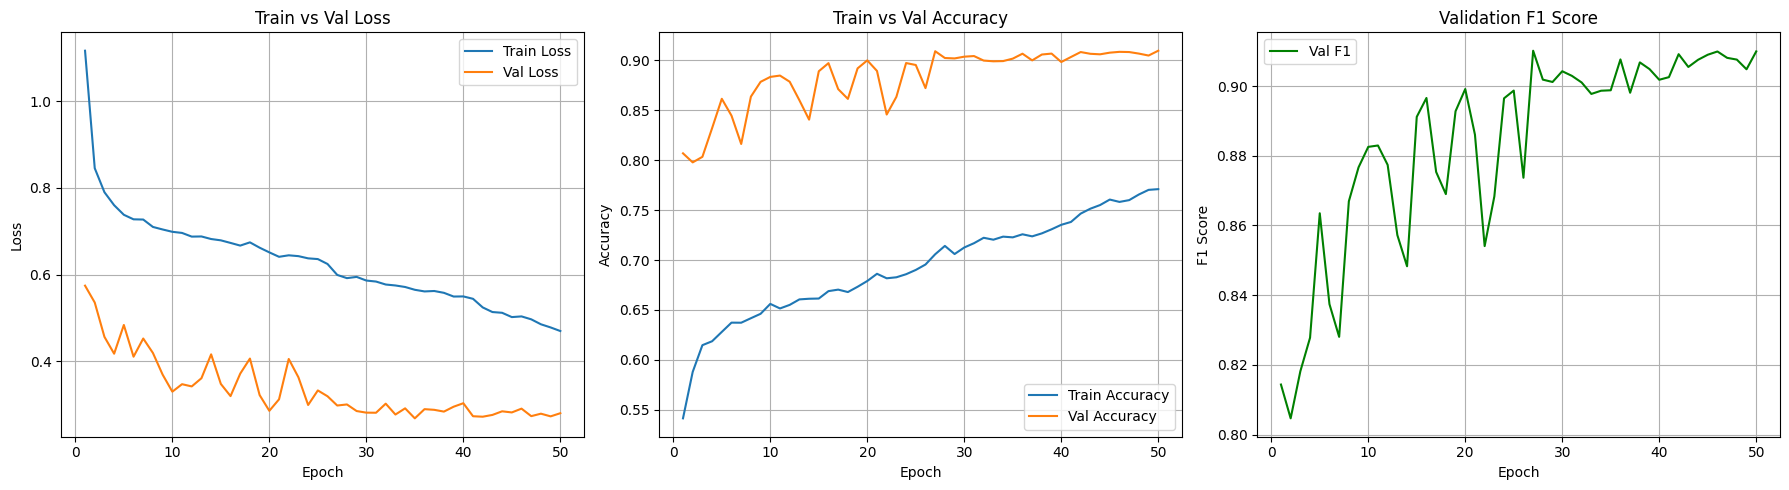


====== Testing the Model ======


Validation: 100%|██████████| 30219/30219 [12:40<00:00, 39.75it/s]



====== Test Results ======
Overall Loss: 0.2774
Overall Accuracy: 0.9091
Cohen's Kappa: 0.8504
Per Class F1: [0.91016526 0.91489144 0.90598992]
Macro (Avg) F1: 0.9103


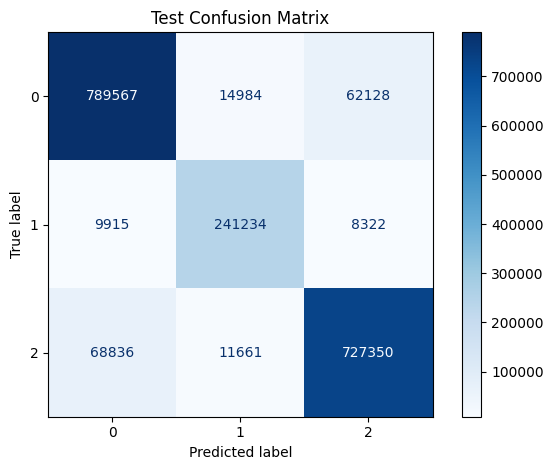

History Dumped in file /kaggle/working/approx_BCNN_data_bvsb_history.json_history.json


====== Loading Data /kaggle/input/data-al/approx_BCNN_data_predictive_entropy.npz ======
Train Data:  (14000, 28, 6) (14000,)


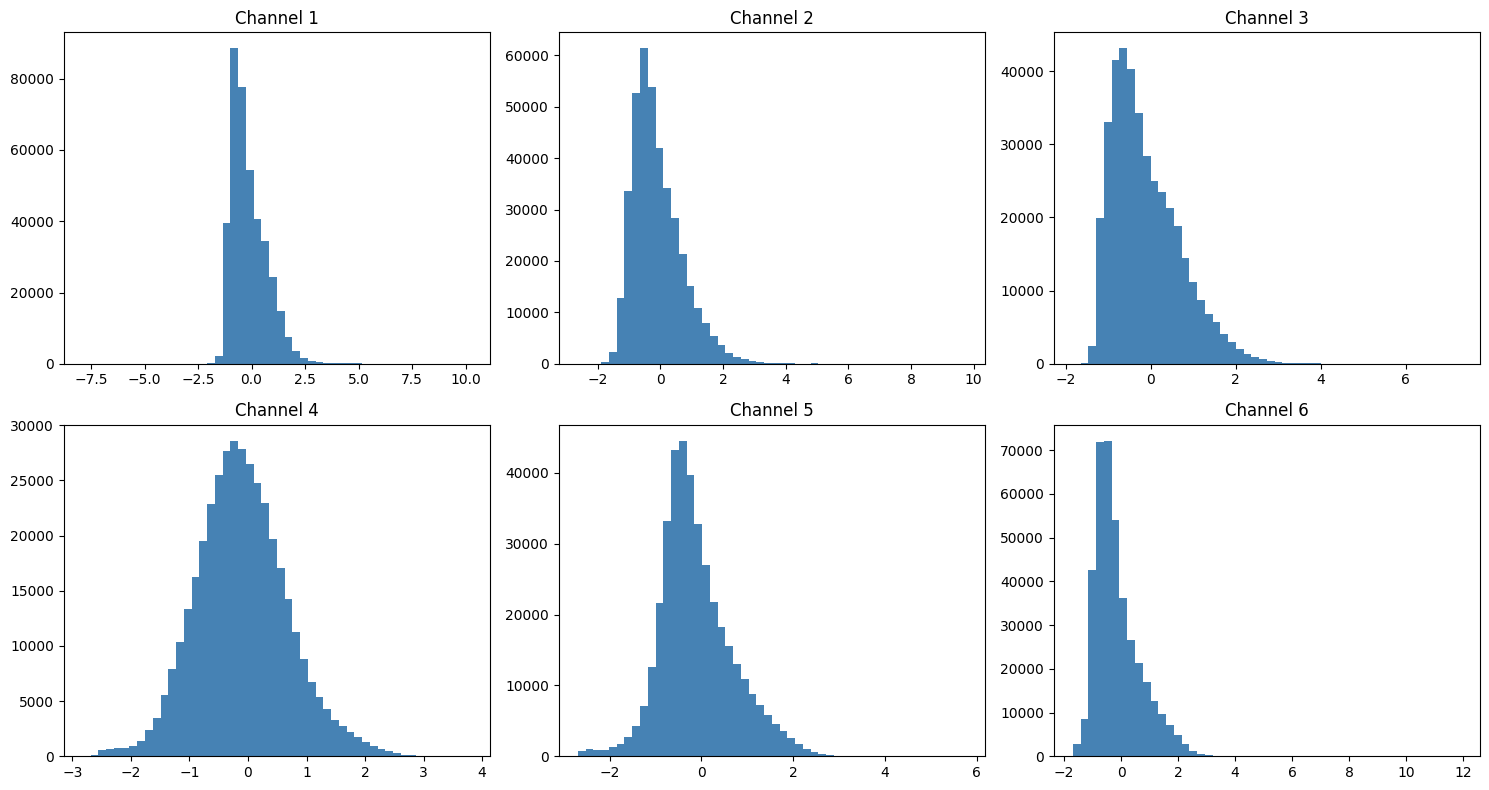

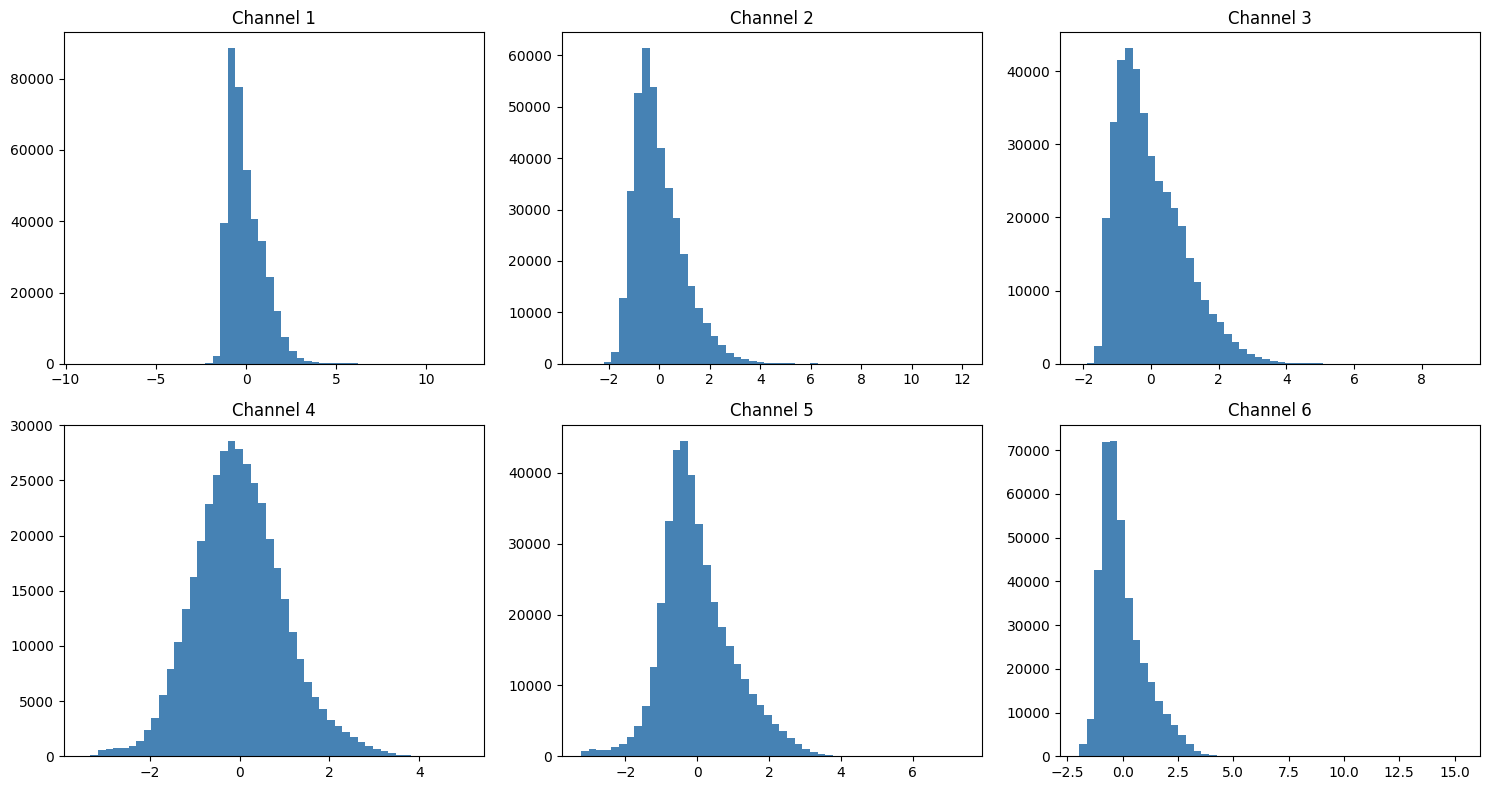



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         5766      41.19%
1         2705      19.32%
2         5529      39.49%

Total samples: 14000


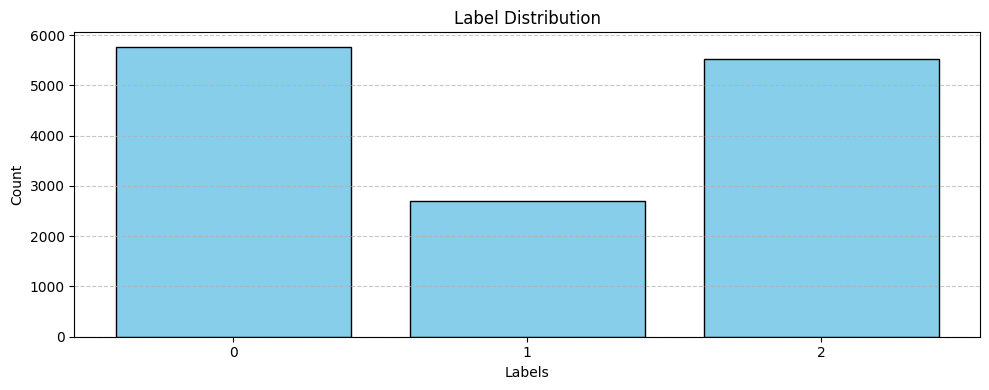


====== Loading Data Site B - 2020 ======
Site B - 2020 Data: (1943716, 28, 6), (1943716,)


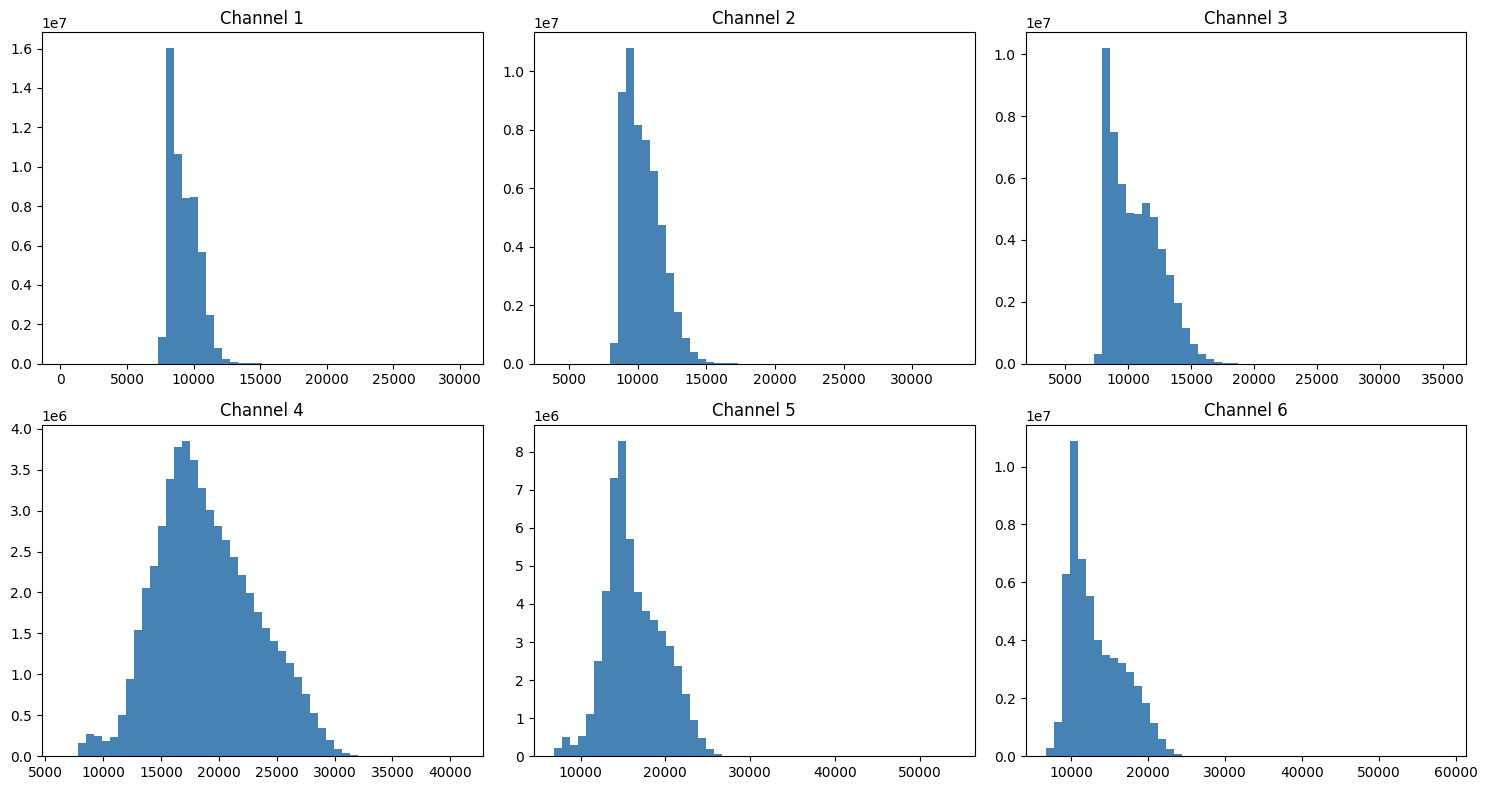

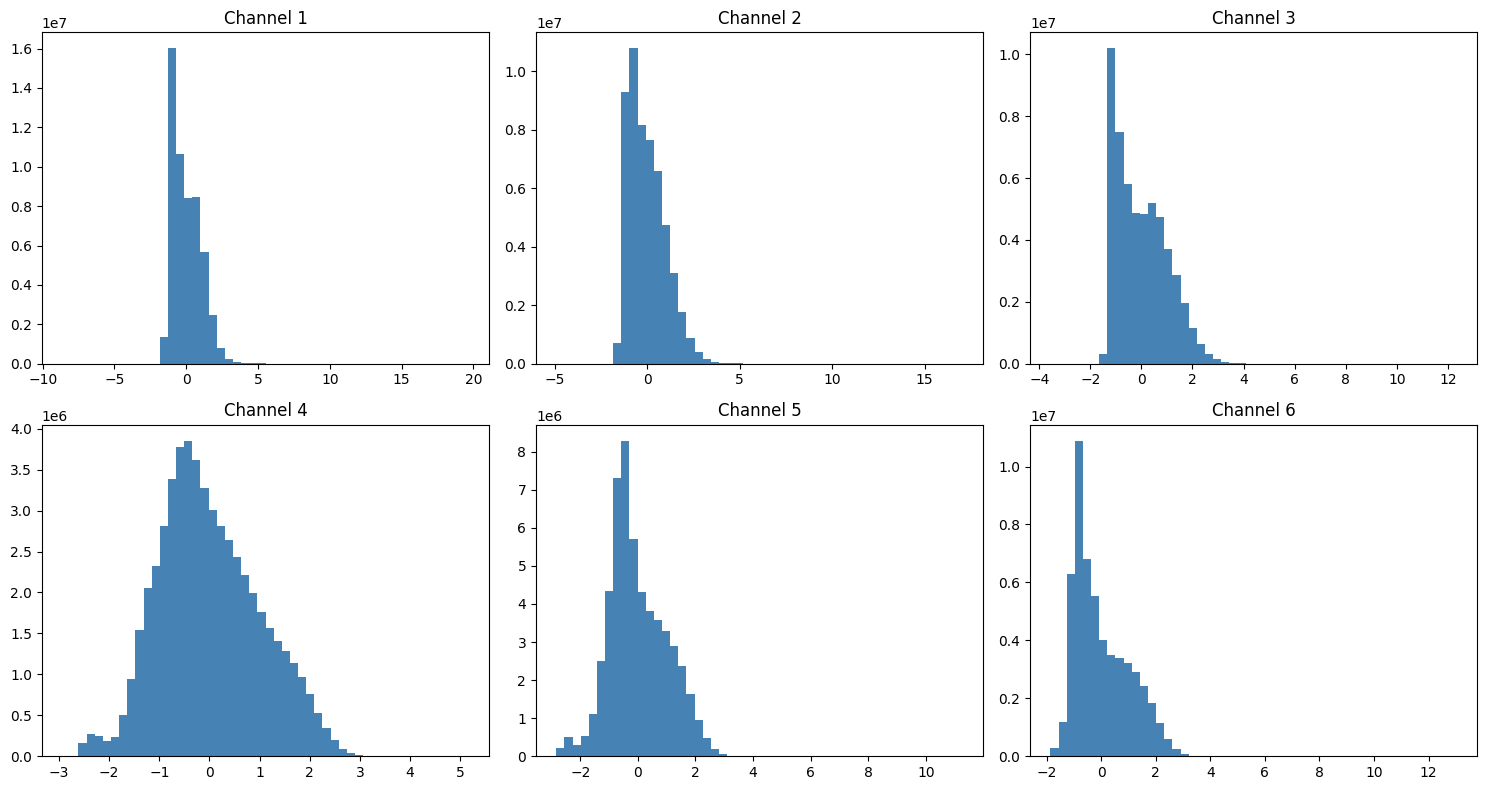



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         871034    44.81%
1         260775    13.42%
2         811907    41.77%

Total samples: 1943716


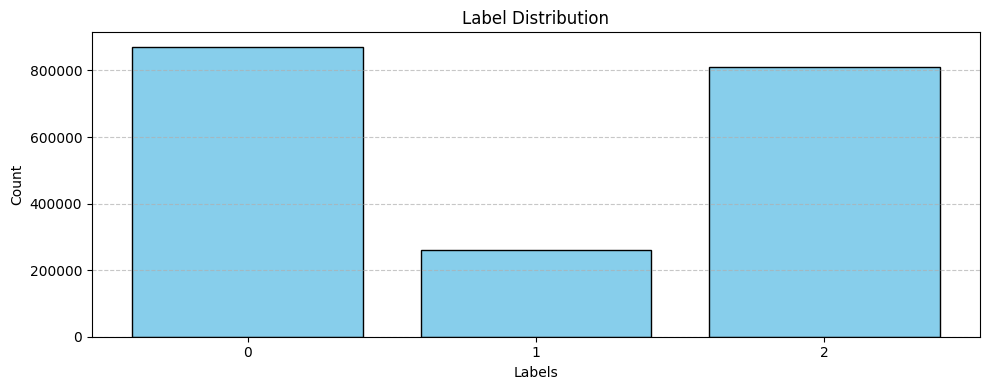

Val Data:  (9719, 28, 6) (9719,)
Test Data:  (1933997, 28, 6) (1933997,)
tensor([0.5930, 1.0025, 0.6120], device='cuda:0')

====== Training the Model ======


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.90it/s]


Epoch [1/50] Train Loss: 1.1306, Train Acc: 0.4956 | Val Loss: 0.5932, Val Acc: 0.7440, F1: 0.7572, Kappa: 0.5886


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.84it/s]


Epoch [2/50] Train Loss: 0.9177, Train Acc: 0.5484 | Val Loss: 0.5998, Val Acc: 0.7580, F1: 0.7593, Kappa: 0.6133


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.88it/s]


Epoch [3/50] Train Loss: 0.8832, Train Acc: 0.5704 | Val Loss: 0.4496, Val Acc: 0.8564, F1: 0.8533, Kappa: 0.7670


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.92it/s]


Epoch [4/50] Train Loss: 0.8649, Train Acc: 0.5808 | Val Loss: 0.4717, Val Acc: 0.8439, F1: 0.8404, Kappa: 0.7483


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.89it/s]


Epoch [5/50] Train Loss: 0.8538, Train Acc: 0.5829 | Val Loss: 0.4644, Val Acc: 0.8518, F1: 0.8552, Kappa: 0.7586


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.82it/s]


Epoch [6/50] Train Loss: 0.8352, Train Acc: 0.5934 | Val Loss: 0.4871, Val Acc: 0.8063, F1: 0.8144, Kappa: 0.6827


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.93it/s]


Epoch [7/50] Train Loss: 0.8277, Train Acc: 0.5965 | Val Loss: 0.4538, Val Acc: 0.8458, F1: 0.8526, Kappa: 0.7480


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.85it/s]


Epoch [8/50] Train Loss: 0.8202, Train Acc: 0.6058 | Val Loss: 0.4370, Val Acc: 0.8499, F1: 0.8546, Kappa: 0.7554


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.85it/s]


Epoch [9/50] Train Loss: 0.8149, Train Acc: 0.6011 | Val Loss: 0.4163, Val Acc: 0.8683, F1: 0.8707, Kappa: 0.7841


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.90it/s]


Epoch [10/50] Train Loss: 0.8111, Train Acc: 0.6059 | Val Loss: 0.5308, Val Acc: 0.8110, F1: 0.8112, Kappa: 0.6946


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.85it/s]


Epoch [11/50] Train Loss: 0.8077, Train Acc: 0.6128 | Val Loss: 0.4318, Val Acc: 0.8528, F1: 0.8560, Kappa: 0.7596


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.84it/s]


Epoch [12/50] Train Loss: 0.8000, Train Acc: 0.6133 | Val Loss: 0.3952, Val Acc: 0.8624, F1: 0.8611, Kappa: 0.7767


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.73it/s]


Epoch [13/50] Train Loss: 0.7918, Train Acc: 0.6187 | Val Loss: 0.3679, Val Acc: 0.8658, F1: 0.8679, Kappa: 0.7812


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.77it/s]


Epoch [14/50] Train Loss: 0.7882, Train Acc: 0.6244 | Val Loss: 0.3529, Val Acc: 0.8763, F1: 0.8768, Kappa: 0.7978


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.77it/s]


Epoch [15/50] Train Loss: 0.7888, Train Acc: 0.6259 | Val Loss: 0.3712, Val Acc: 0.8794, F1: 0.8802, Kappa: 0.8021


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.88it/s]


Epoch [16/50] Train Loss: 0.7795, Train Acc: 0.6276 | Val Loss: 0.3429, Val Acc: 0.8765, F1: 0.8777, Kappa: 0.7980


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.89it/s]


Epoch [17/50] Train Loss: 0.7796, Train Acc: 0.6258 | Val Loss: 0.4807, Val Acc: 0.7995, F1: 0.8117, Kappa: 0.6716


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.81it/s]


Epoch [18/50] Train Loss: 0.7811, Train Acc: 0.6236 | Val Loss: 0.3481, Val Acc: 0.8773, F1: 0.8820, Kappa: 0.7988


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.89it/s]


Epoch [19/50] Train Loss: 0.7708, Train Acc: 0.6329 | Val Loss: 0.3563, Val Acc: 0.8797, F1: 0.8829, Kappa: 0.8027


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.96it/s]


Epoch [20/50] Train Loss: 0.7664, Train Acc: 0.6306 | Val Loss: 0.3517, Val Acc: 0.8742, F1: 0.8764, Kappa: 0.7939


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.90it/s]


Epoch [21/50] Train Loss: 0.7664, Train Acc: 0.6336 | Val Loss: 0.3263, Val Acc: 0.8787, F1: 0.8792, Kappa: 0.8019


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.84it/s]


Epoch [22/50] Train Loss: 0.7601, Train Acc: 0.6406 | Val Loss: 0.3581, Val Acc: 0.8619, F1: 0.8646, Kappa: 0.7751


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.88it/s]


Epoch [23/50] Train Loss: 0.7551, Train Acc: 0.6442 | Val Loss: 0.4213, Val Acc: 0.8386, F1: 0.8454, Kappa: 0.7374


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.86it/s]


Epoch [24/50] Train Loss: 0.7556, Train Acc: 0.6419 | Val Loss: 0.3648, Val Acc: 0.8703, F1: 0.8711, Kappa: 0.7879


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.85it/s]


Epoch [25/50] Train Loss: 0.7519, Train Acc: 0.6398 | Val Loss: 0.3298, Val Acc: 0.8835, F1: 0.8838, Kappa: 0.8095


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.87it/s]


Epoch [26/50] Train Loss: 0.7500, Train Acc: 0.6426 | Val Loss: 0.3510, Val Acc: 0.8712, F1: 0.8717, Kappa: 0.7901


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.90it/s]


Epoch [27/50] Train Loss: 0.7459, Train Acc: 0.6475 | Val Loss: 0.3188, Val Acc: 0.8844, F1: 0.8846, Kappa: 0.8108


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.84it/s]


Epoch [28/50] Train Loss: 0.7428, Train Acc: 0.6475 | Val Loss: 0.3141, Val Acc: 0.8878, F1: 0.8895, Kappa: 0.8164


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.86it/s]


Epoch [29/50] Train Loss: 0.7301, Train Acc: 0.6580 | Val Loss: 0.3811, Val Acc: 0.8648, F1: 0.8708, Kappa: 0.7768


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.86it/s]


Epoch [30/50] Train Loss: 0.7327, Train Acc: 0.6530 | Val Loss: 0.3673, Val Acc: 0.8617, F1: 0.8655, Kappa: 0.7741


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.86it/s]


Epoch [31/50] Train Loss: 0.7325, Train Acc: 0.6581 | Val Loss: 0.3245, Val Acc: 0.8786, F1: 0.8801, Kappa: 0.8015


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.90it/s]


Epoch [32/50] Train Loss: 0.7257, Train Acc: 0.6606 | Val Loss: 0.3206, Val Acc: 0.8870, F1: 0.8896, Kappa: 0.8151


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.81it/s]


Epoch [33/50] Train Loss: 0.7266, Train Acc: 0.6584 | Val Loss: 0.3240, Val Acc: 0.8800, F1: 0.8794, Kappa: 0.8043


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.85it/s]


Epoch [34/50] Train Loss: 0.7218, Train Acc: 0.6636 | Val Loss: 0.3361, Val Acc: 0.8786, F1: 0.8767, Kappa: 0.8018


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.86it/s]


Epoch [35/50] Train Loss: 0.6957, Train Acc: 0.6781 | Val Loss: 0.3141, Val Acc: 0.8790, F1: 0.8843, Kappa: 0.8013


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.85it/s]


Epoch [36/50] Train Loss: 0.6858, Train Acc: 0.6790 | Val Loss: 0.3108, Val Acc: 0.8856, F1: 0.8859, Kappa: 0.8131


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.85it/s]


Epoch [37/50] Train Loss: 0.6790, Train Acc: 0.6853 | Val Loss: 0.2964, Val Acc: 0.8940, F1: 0.8962, Kappa: 0.8261


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.89it/s]


Epoch [38/50] Train Loss: 0.6733, Train Acc: 0.6919 | Val Loss: 0.3168, Val Acc: 0.8851, F1: 0.8884, Kappa: 0.8111


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.90it/s]


Epoch [39/50] Train Loss: 0.6730, Train Acc: 0.6883 | Val Loss: 0.3244, Val Acc: 0.8842, F1: 0.8859, Kappa: 0.8102


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.93it/s]


Epoch [40/50] Train Loss: 0.6654, Train Acc: 0.6954 | Val Loss: 0.3116, Val Acc: 0.8859, F1: 0.8875, Kappa: 0.8131


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.88it/s]


Epoch [41/50] Train Loss: 0.6674, Train Acc: 0.6944 | Val Loss: 0.3154, Val Acc: 0.8842, F1: 0.8839, Kappa: 0.8109


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.85it/s]


Epoch [42/50] Train Loss: 0.6666, Train Acc: 0.6956 | Val Loss: 0.3268, Val Acc: 0.8863, F1: 0.8886, Kappa: 0.8135


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.87it/s]


Epoch [43/50] Train Loss: 0.6484, Train Acc: 0.7048 | Val Loss: 0.3138, Val Acc: 0.8893, F1: 0.8913, Kappa: 0.8184


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.86it/s]


Epoch [44/50] Train Loss: 0.6409, Train Acc: 0.7056 | Val Loss: 0.2977, Val Acc: 0.8977, F1: 0.9000, Kappa: 0.8316


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.81it/s]


Epoch [45/50] Train Loss: 0.6305, Train Acc: 0.7126 | Val Loss: 0.3143, Val Acc: 0.8867, F1: 0.8887, Kappa: 0.8141


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.86it/s]


Epoch [46/50] Train Loss: 0.6238, Train Acc: 0.7195 | Val Loss: 0.3027, Val Acc: 0.8868, F1: 0.8885, Kappa: 0.8147


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.83it/s]


Epoch [47/50] Train Loss: 0.6204, Train Acc: 0.7206 | Val Loss: 0.3050, Val Acc: 0.8904, F1: 0.8913, Kappa: 0.8205


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.86it/s]


Epoch [48/50] Train Loss: 0.6264, Train Acc: 0.7131 | Val Loss: 0.3082, Val Acc: 0.8895, F1: 0.8916, Kappa: 0.8188


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.87it/s]


Epoch [49/50] Train Loss: 0.6116, Train Acc: 0.7204 | Val Loss: 0.3084, Val Acc: 0.8929, F1: 0.8948, Kappa: 0.8239


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.82it/s]


Epoch [50/50] Train Loss: 0.6065, Train Acc: 0.7241 | Val Loss: 0.3062, Val Acc: 0.8953, F1: 0.8971, Kappa: 0.8277


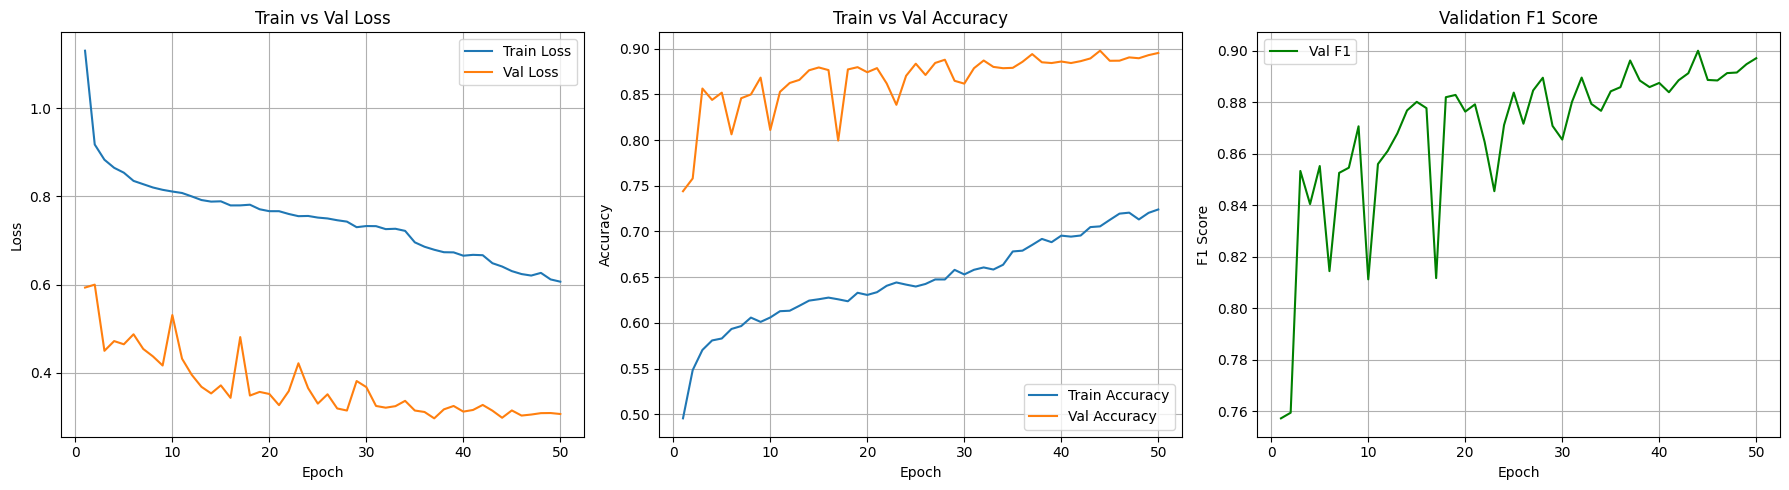


====== Testing the Model ======


Validation: 100%|██████████| 30219/30219 [12:40<00:00, 39.74it/s]



====== Test Results ======
Overall Loss: 0.3071
Overall Accuracy: 0.8946
Cohen's Kappa: 0.8265
Per Class F1: [0.8950029  0.91102311 0.88874969]
Macro (Avg) F1: 0.8983


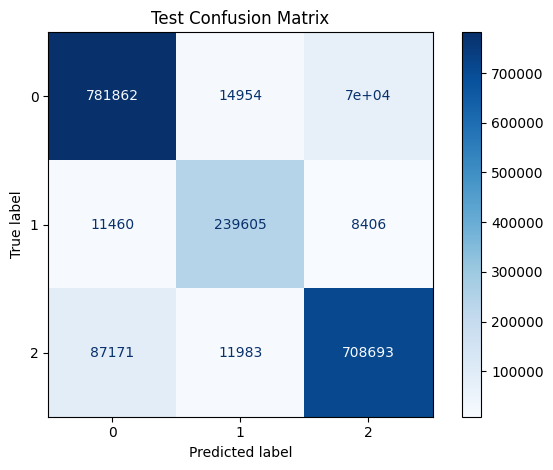

History Dumped in file /kaggle/working/approx_BCNN_data_predictive_entropy_history.json_history.json


====== Loading Data /kaggle/input/data-al/approx_BCNN_data_variation_ratio.npz ======
Train Data:  (14000, 28, 6) (14000,)


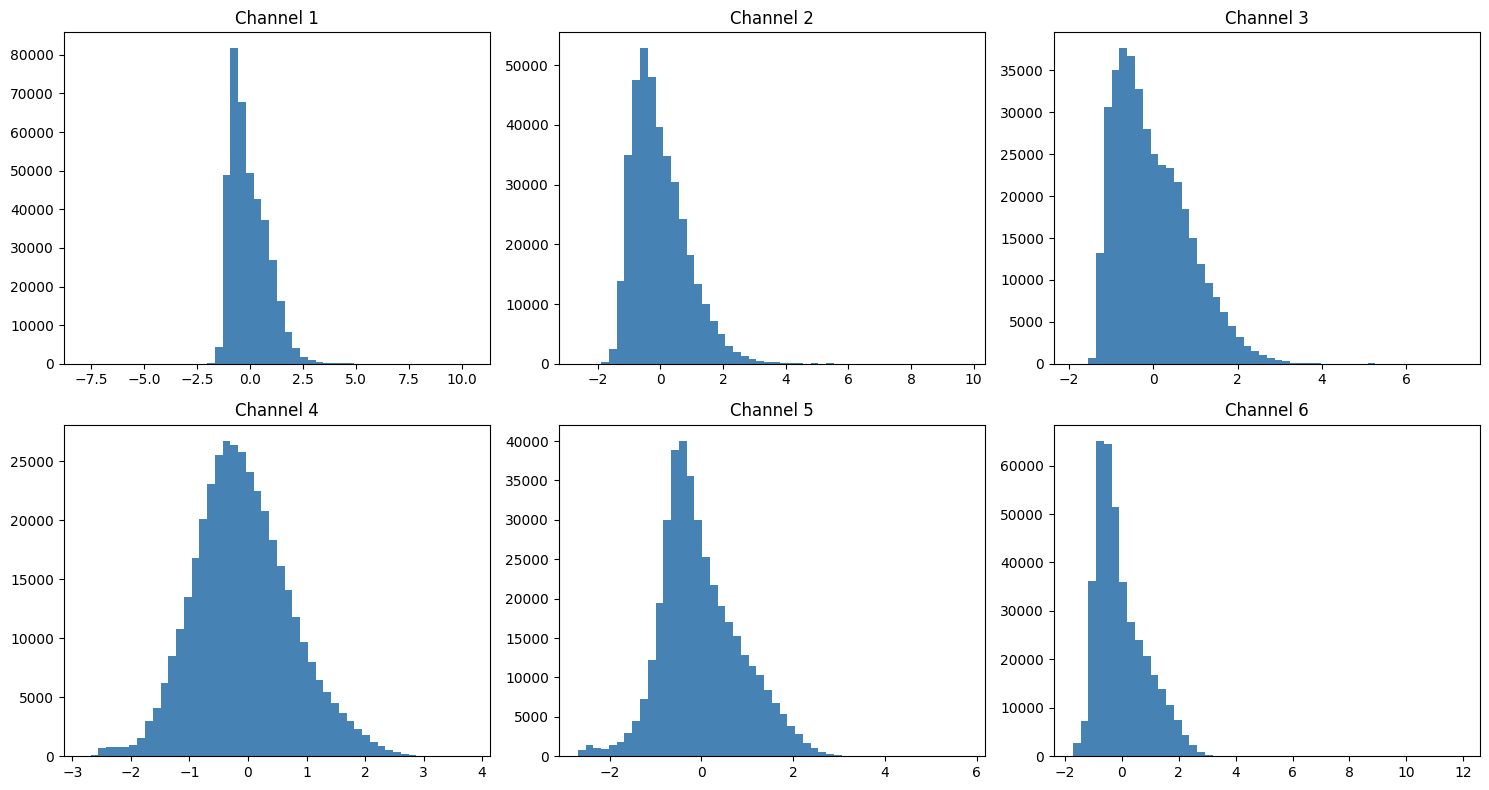

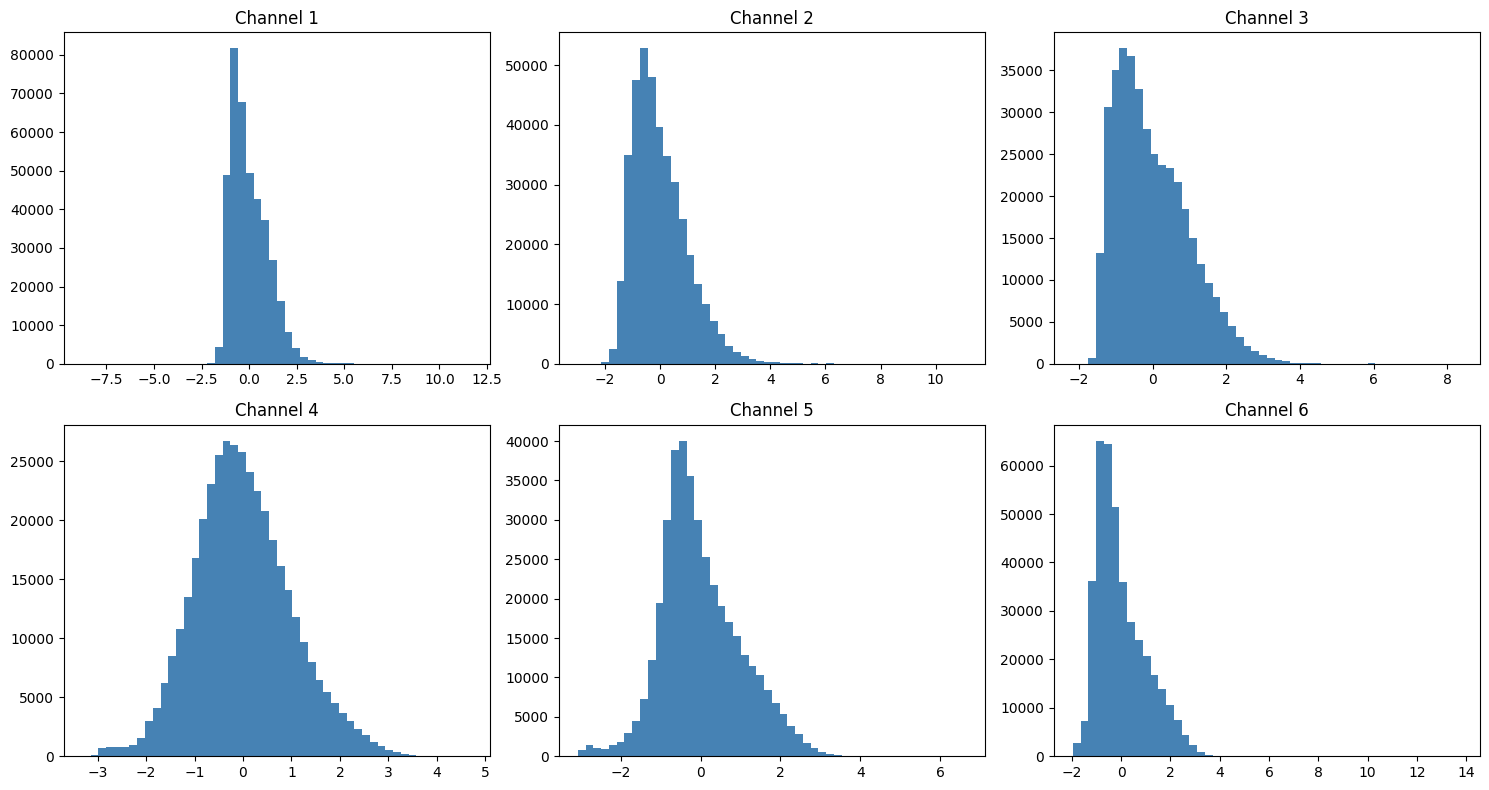



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         6050      43.21%
1         1913      13.66%
2         6037      43.12%

Total samples: 14000


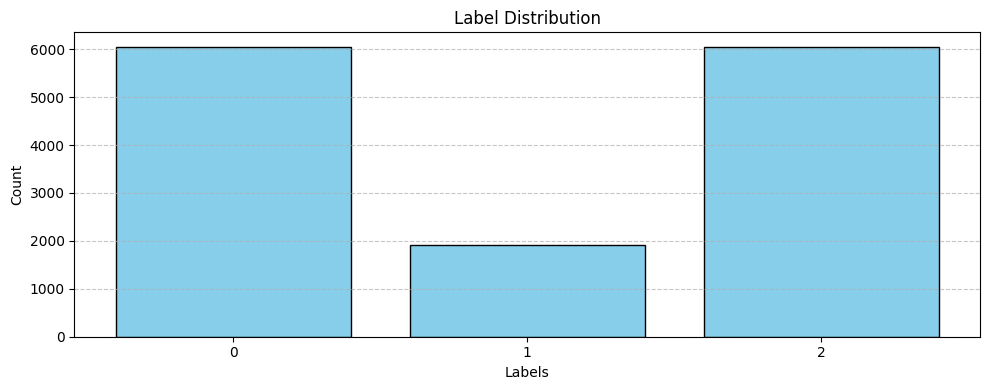


====== Loading Data Site B - 2020 ======
Site B - 2020 Data: (1943716, 28, 6), (1943716,)


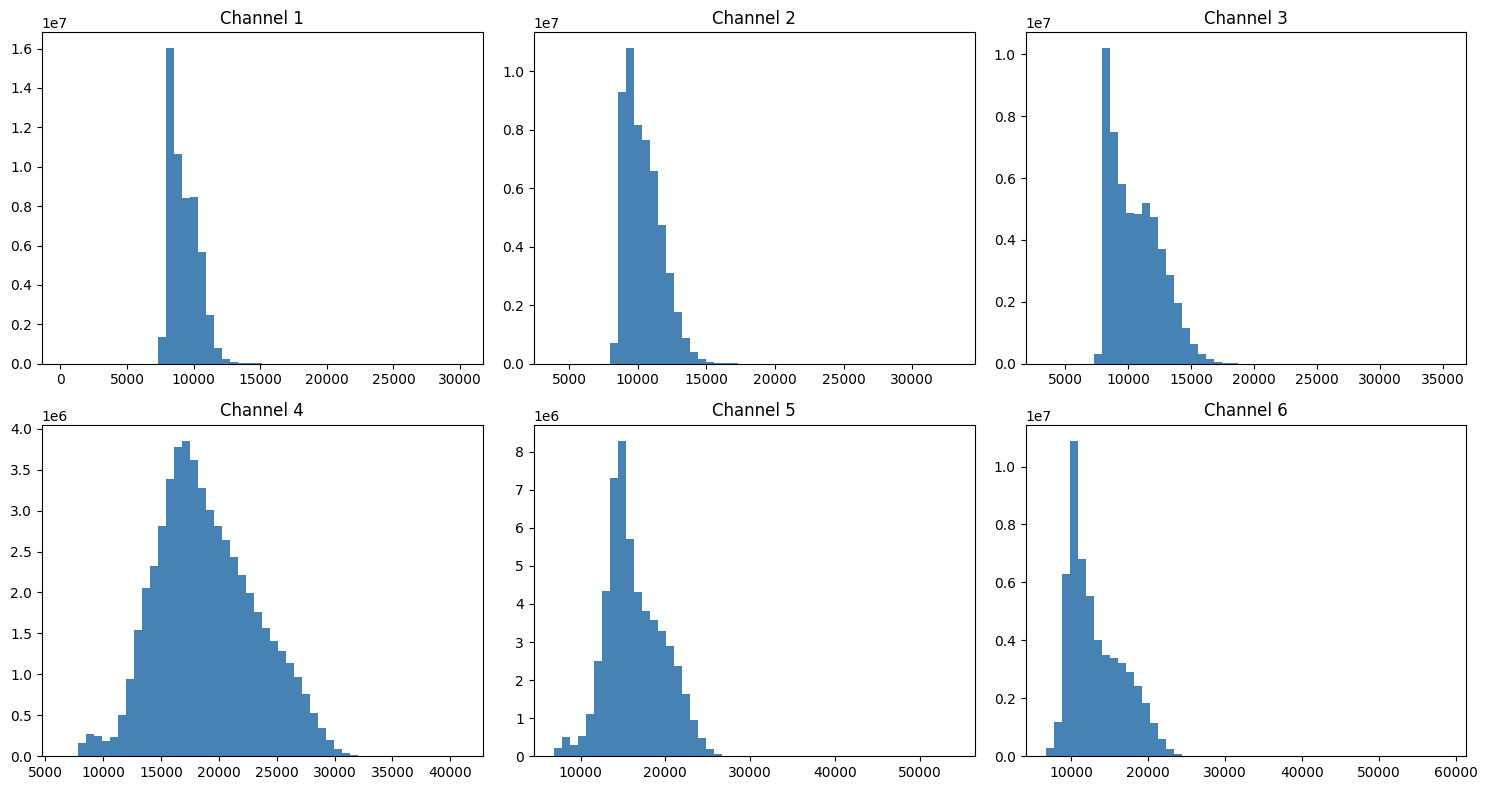

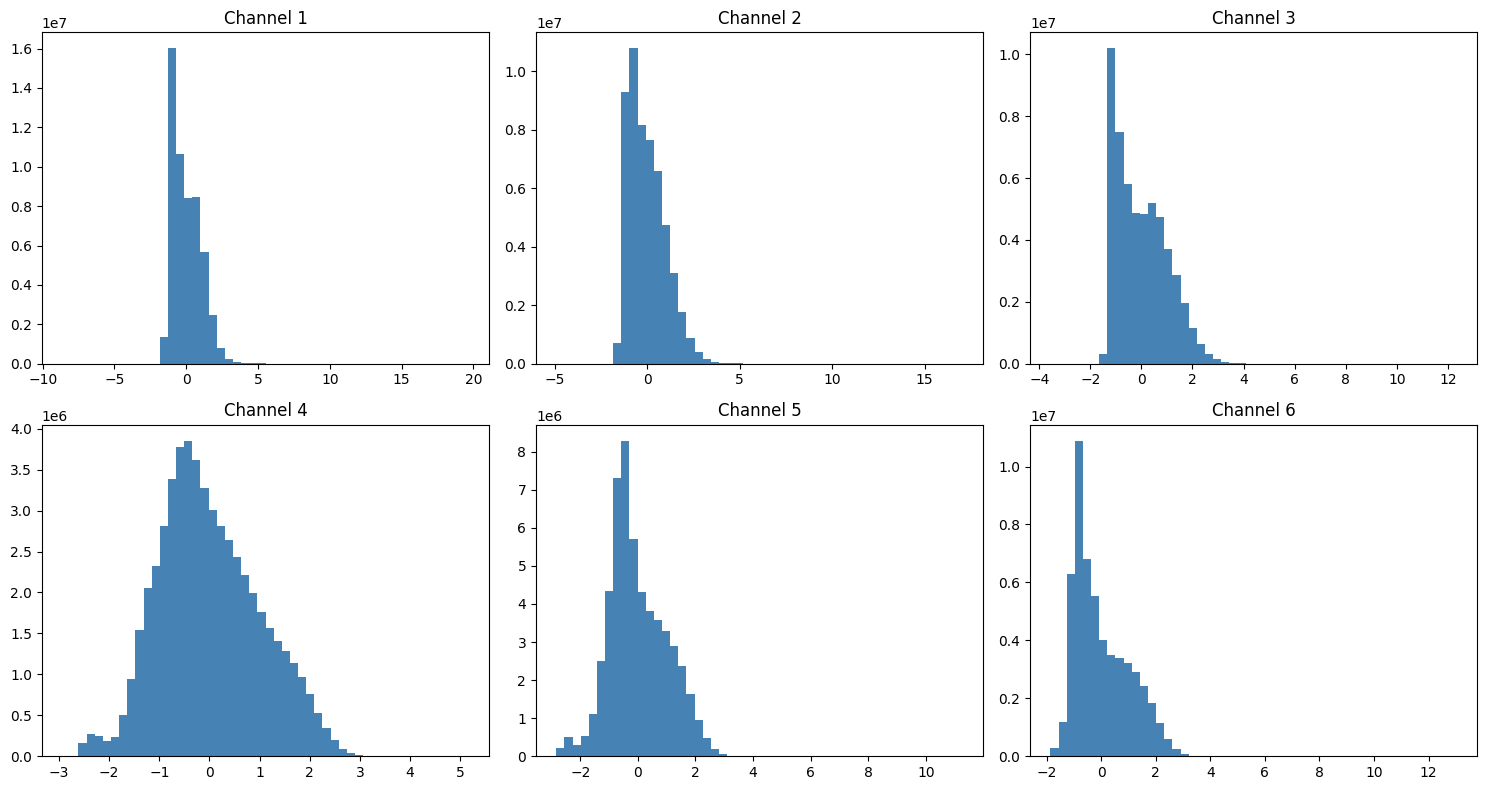



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         871034    44.81%
1         260775    13.42%
2         811907    41.77%

Total samples: 1943716


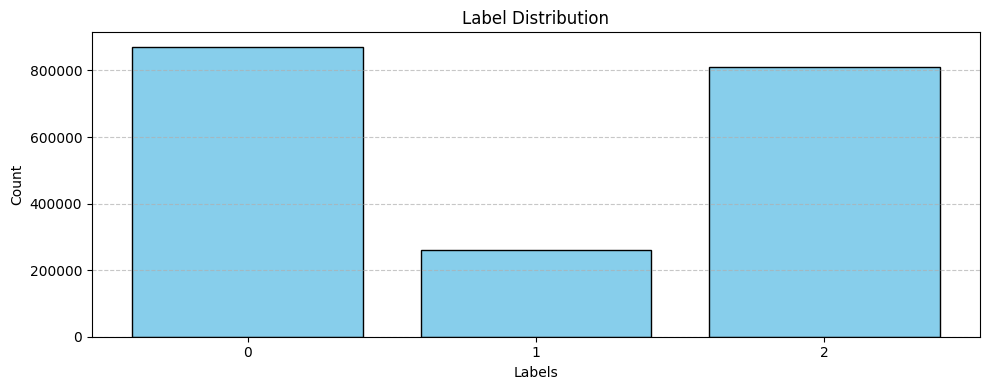

Val Data:  (9719, 28, 6) (9719,)
Test Data:  (1933997, 28, 6) (1933997,)
tensor([0.5717, 1.2353, 0.5727], device='cuda:0')

====== Training the Model ======


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.89it/s]


Epoch [1/50] Train Loss: 1.0601, Train Acc: 0.5333 | Val Loss: 0.5621, Val Acc: 0.7107, F1: 0.7250, Kappa: 0.5371


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.80it/s]


Epoch [2/50] Train Loss: 0.8469, Train Acc: 0.5796 | Val Loss: 0.4265, Val Acc: 0.8599, F1: 0.8614, Kappa: 0.7717


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.71it/s]


Epoch [3/50] Train Loss: 0.8101, Train Acc: 0.5989 | Val Loss: 0.4364, Val Acc: 0.8556, F1: 0.8560, Kappa: 0.7650


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.89it/s]


Epoch [4/50] Train Loss: 0.7899, Train Acc: 0.6080 | Val Loss: 0.4208, Val Acc: 0.8395, F1: 0.8467, Kappa: 0.7387


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.87it/s]


Epoch [5/50] Train Loss: 0.7802, Train Acc: 0.6119 | Val Loss: 0.4279, Val Acc: 0.8778, F1: 0.8813, Kappa: 0.7992


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.88it/s]


Epoch [6/50] Train Loss: 0.7647, Train Acc: 0.6267 | Val Loss: 0.3942, Val Acc: 0.8696, F1: 0.8698, Kappa: 0.7875


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.75it/s]


Epoch [7/50] Train Loss: 0.7479, Train Acc: 0.6304 | Val Loss: 0.3869, Val Acc: 0.8810, F1: 0.8864, Kappa: 0.8045


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.83it/s]


Epoch [8/50] Train Loss: 0.7432, Train Acc: 0.6309 | Val Loss: 0.3638, Val Acc: 0.8695, F1: 0.8703, Kappa: 0.7870


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.78it/s]


Epoch [9/50] Train Loss: 0.7390, Train Acc: 0.6352 | Val Loss: 0.3581, Val Acc: 0.8947, F1: 0.8983, Kappa: 0.8267


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.95it/s]


Epoch [10/50] Train Loss: 0.7343, Train Acc: 0.6412 | Val Loss: 0.3466, Val Acc: 0.8804, F1: 0.8789, Kappa: 0.8050


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.70it/s]


Epoch [11/50] Train Loss: 0.7195, Train Acc: 0.6455 | Val Loss: 0.3513, Val Acc: 0.8776, F1: 0.8786, Kappa: 0.7998


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.81it/s]


Epoch [12/50] Train Loss: 0.7222, Train Acc: 0.6405 | Val Loss: 0.4070, Val Acc: 0.8563, F1: 0.8625, Kappa: 0.7645


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.05it/s]


Epoch [13/50] Train Loss: 0.7181, Train Acc: 0.6517 | Val Loss: 0.3563, Val Acc: 0.8929, F1: 0.8965, Kappa: 0.8238


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.88it/s]


Epoch [14/50] Train Loss: 0.7055, Train Acc: 0.6494 | Val Loss: 0.3339, Val Acc: 0.8819, F1: 0.8844, Kappa: 0.8070


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.76it/s]


Epoch [15/50] Train Loss: 0.6985, Train Acc: 0.6586 | Val Loss: 0.3155, Val Acc: 0.8870, F1: 0.8862, Kappa: 0.8157


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.81it/s]


Epoch [16/50] Train Loss: 0.7024, Train Acc: 0.6577 | Val Loss: 0.3471, Val Acc: 0.8936, F1: 0.8965, Kappa: 0.8249


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.67it/s]


Epoch [17/50] Train Loss: 0.6930, Train Acc: 0.6690 | Val Loss: 0.3495, Val Acc: 0.8901, F1: 0.8938, Kappa: 0.8195


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.88it/s]


Epoch [18/50] Train Loss: 0.6899, Train Acc: 0.6658 | Val Loss: 0.4566, Val Acc: 0.8110, F1: 0.8230, Kappa: 0.6864


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.86it/s]


Epoch [19/50] Train Loss: 0.6901, Train Acc: 0.6654 | Val Loss: 0.3233, Val Acc: 0.9018, F1: 0.9022, Kappa: 0.8389


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.84it/s]


Epoch [20/50] Train Loss: 0.6850, Train Acc: 0.6680 | Val Loss: 0.3400, Val Acc: 0.8694, F1: 0.8713, Kappa: 0.7872


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.74it/s]


Epoch [21/50] Train Loss: 0.6803, Train Acc: 0.6686 | Val Loss: 0.3091, Val Acc: 0.8838, F1: 0.8853, Kappa: 0.8101


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.87it/s]


Epoch [22/50] Train Loss: 0.6813, Train Acc: 0.6690 | Val Loss: 0.3295, Val Acc: 0.8895, F1: 0.8922, Kappa: 0.8184


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.89it/s]


Epoch [23/50] Train Loss: 0.6774, Train Acc: 0.6726 | Val Loss: 0.3108, Val Acc: 0.8828, F1: 0.8842, Kappa: 0.8088


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.85it/s]


Epoch [24/50] Train Loss: 0.6706, Train Acc: 0.6735 | Val Loss: 0.3274, Val Acc: 0.8848, F1: 0.8873, Kappa: 0.8112


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.84it/s]


Epoch [25/50] Train Loss: 0.6666, Train Acc: 0.6761 | Val Loss: 0.3116, Val Acc: 0.9004, F1: 0.9029, Kappa: 0.8361


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.91it/s]


Epoch [26/50] Train Loss: 0.6656, Train Acc: 0.6746 | Val Loss: 0.2955, Val Acc: 0.9020, F1: 0.9020, Kappa: 0.8394


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.74it/s]


Epoch [27/50] Train Loss: 0.6553, Train Acc: 0.6870 | Val Loss: 0.2930, Val Acc: 0.8958, F1: 0.8948, Kappa: 0.8296


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.85it/s]


Epoch [28/50] Train Loss: 0.6549, Train Acc: 0.6832 | Val Loss: 0.3042, Val Acc: 0.8941, F1: 0.8958, Kappa: 0.8263


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.89it/s]


Epoch [29/50] Train Loss: 0.6573, Train Acc: 0.6860 | Val Loss: 0.3238, Val Acc: 0.8860, F1: 0.8914, Kappa: 0.8122


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.80it/s]


Epoch [30/50] Train Loss: 0.6452, Train Acc: 0.6886 | Val Loss: 0.3240, Val Acc: 0.8887, F1: 0.8899, Kappa: 0.8173


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.83it/s]


Epoch [31/50] Train Loss: 0.6382, Train Acc: 0.6916 | Val Loss: 0.2962, Val Acc: 0.8913, F1: 0.8918, Kappa: 0.8222


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.92it/s]


Epoch [32/50] Train Loss: 0.6390, Train Acc: 0.6912 | Val Loss: 0.3331, Val Acc: 0.8967, F1: 0.8953, Kappa: 0.8286


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.81it/s]


Epoch [33/50] Train Loss: 0.6353, Train Acc: 0.6929 | Val Loss: 0.2833, Val Acc: 0.9005, F1: 0.9009, Kappa: 0.8367


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.89it/s]


Epoch [34/50] Train Loss: 0.6232, Train Acc: 0.7031 | Val Loss: 0.3113, Val Acc: 0.8997, F1: 0.9016, Kappa: 0.8349


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.87it/s]


Epoch [35/50] Train Loss: 0.6272, Train Acc: 0.6992 | Val Loss: 0.2905, Val Acc: 0.8992, F1: 0.9000, Kappa: 0.8348


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.92it/s]


Epoch [36/50] Train Loss: 0.6177, Train Acc: 0.7066 | Val Loss: 0.2841, Val Acc: 0.9043, F1: 0.9065, Kappa: 0.8424


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.87it/s]


Epoch [37/50] Train Loss: 0.6249, Train Acc: 0.6996 | Val Loss: 0.2941, Val Acc: 0.9007, F1: 0.9027, Kappa: 0.8368


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.90it/s]


Epoch [38/50] Train Loss: 0.6191, Train Acc: 0.7066 | Val Loss: 0.3283, Val Acc: 0.8945, F1: 0.8949, Kappa: 0.8261


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.86it/s]


Epoch [39/50] Train Loss: 0.6129, Train Acc: 0.7049 | Val Loss: 0.2841, Val Acc: 0.8957, F1: 0.8956, Kappa: 0.8294


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.94it/s]


Epoch [40/50] Train Loss: 0.5843, Train Acc: 0.7244 | Val Loss: 0.2817, Val Acc: 0.9026, F1: 0.9033, Kappa: 0.8400


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.83it/s]


Epoch [41/50] Train Loss: 0.5741, Train Acc: 0.7279 | Val Loss: 0.2797, Val Acc: 0.9024, F1: 0.9012, Kappa: 0.8400


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.97it/s]


Epoch [42/50] Train Loss: 0.5698, Train Acc: 0.7283 | Val Loss: 0.2753, Val Acc: 0.9042, F1: 0.9037, Kappa: 0.8428


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.79it/s]


Epoch [43/50] Train Loss: 0.5651, Train Acc: 0.7331 | Val Loss: 0.2735, Val Acc: 0.9060, F1: 0.9062, Kappa: 0.8454


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.91it/s]


Epoch [44/50] Train Loss: 0.5608, Train Acc: 0.7349 | Val Loss: 0.2760, Val Acc: 0.9040, F1: 0.9064, Kappa: 0.8423


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.89it/s]


Epoch [45/50] Train Loss: 0.5578, Train Acc: 0.7392 | Val Loss: 0.2755, Val Acc: 0.9070, F1: 0.9086, Kappa: 0.8466


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.89it/s]


Epoch [46/50] Train Loss: 0.5583, Train Acc: 0.7336 | Val Loss: 0.2759, Val Acc: 0.9053, F1: 0.9056, Kappa: 0.8446


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.90it/s]


Epoch [47/50] Train Loss: 0.5526, Train Acc: 0.7396 | Val Loss: 0.2799, Val Acc: 0.9054, F1: 0.9069, Kappa: 0.8445


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.91it/s]


Epoch [48/50] Train Loss: 0.5460, Train Acc: 0.7422 | Val Loss: 0.2744, Val Acc: 0.9069, F1: 0.9078, Kappa: 0.8471


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.86it/s]


Epoch [49/50] Train Loss: 0.5482, Train Acc: 0.7399 | Val Loss: 0.2751, Val Acc: 0.9055, F1: 0.9060, Kappa: 0.8449


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.87it/s]


Epoch [50/50] Train Loss: 0.5250, Train Acc: 0.7571 | Val Loss: 0.2753, Val Acc: 0.9065, F1: 0.9084, Kappa: 0.8461


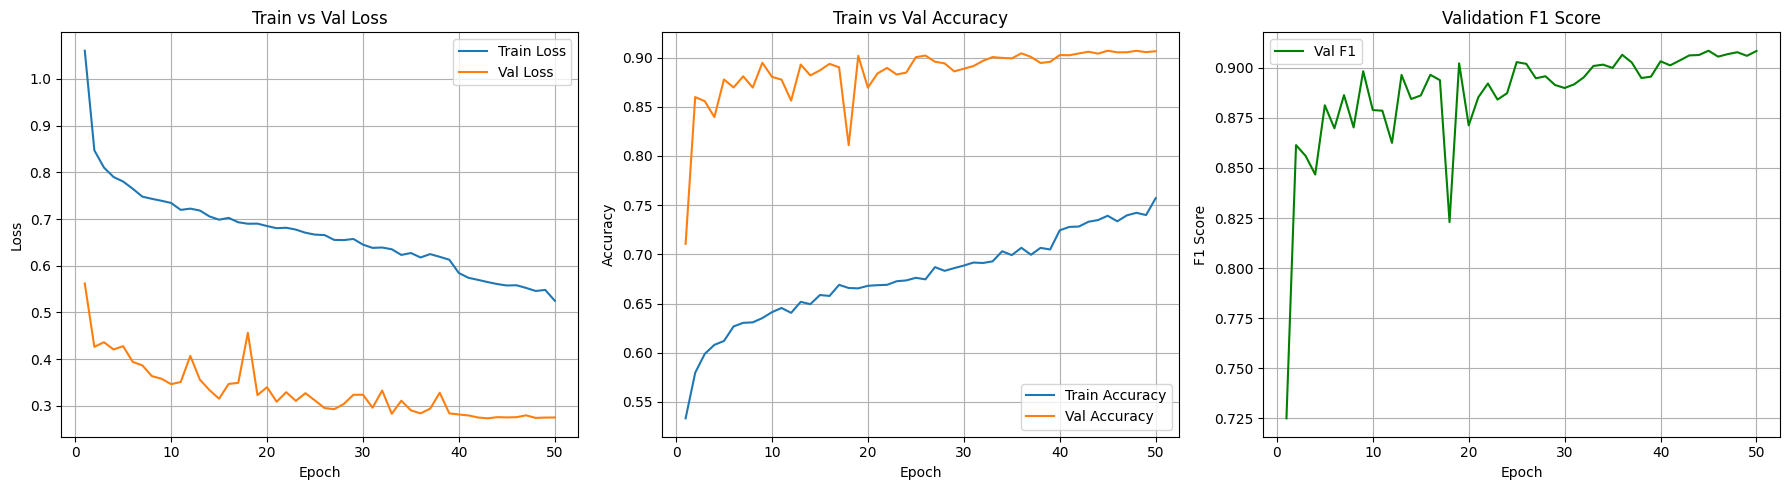


====== Testing the Model ======


Validation: 100%|██████████| 30219/30219 [12:41<00:00, 39.70it/s]



====== Test Results ======
Overall Loss: 0.2761
Overall Accuracy: 0.9057
Cohen's Kappa: 0.8447
Per Class F1: [0.90377375 0.92123705 0.90281586]
Macro (Avg) F1: 0.9093


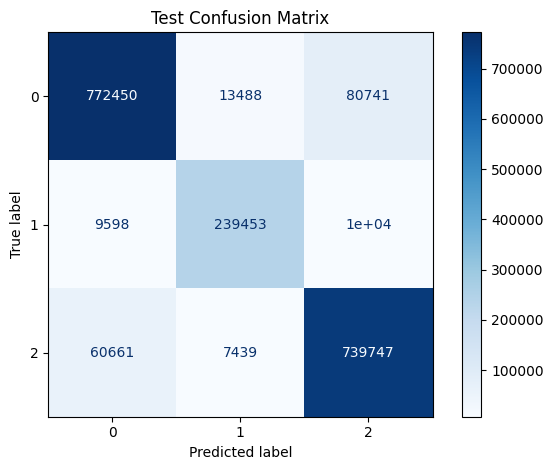

History Dumped in file /kaggle/working/approx_BCNN_data_variation_ratio_history.json_history.json
Saved history of all files to approx_BCNN_training_evaluation.xlsx


In [18]:
for name in file_names:
    print(f'\n\n====== Loading Data {name} ======')
    X_train, y_train = load_data(name)
    
    if X_train.shape[1:] == (6,28):
        X_train = X_train.transpose(0,2,1)
    
    print('Train Data: ', X_train.shape, y_train.shape)
    plot_input_dist(X_train)
    X_train = normalize(X_train)
    plot_input_dist(X_train)
    plot_label_dist(y_train)

    print(f'\n====== Loading Data Site {SITE} - {YEAR} ======')
    X_B2020, y_B2020 = load_data(X_B2020_path, y_B2020_path)
    print(f'Site {SITE} - {YEAR} Data: {X_B2020.shape}, {y_B2020.shape}')
    plot_input_dist(X_B2020)
    X_B2020 = normalize(X_B2020)
    plot_input_dist(X_B2020)
    plot_label_dist(y_B2020)

    # Data Split
    X_test, X_val, y_test, y_val = train_test_split(X_B2020, y_B2020, test_size=0.005, stratify=y_B2020, random_state=42)
    print(f'Val Data: ', X_val.shape, y_val.shape)
    print(f'Test Data: ', X_test.shape, y_test.shape)

    # Creating datasets and dataloaders
    train_dataset = Conv1dDataset(X_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    val_dataset = Conv1dDataset(X_val, y_val)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    test_dataset = Conv1dDataset(X_test, y_test)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Model Initialization
    backbone = cnn_dropout().to(DEVICE)
    fc = FC_dropout(1024).to(DEVICE)
    backbone.load_state_dict(backbone_state)
    fc.load_state_dict(fc_state)

    # ===== Class weights =====
    all_labels = np.array(y_train)  # shape: (num_samples, H, W) if segmentation

    # Flatten labels and count occurrences
    flattened = all_labels.flatten()
    flattened = flattened[flattened >= 0]
    class_counts = np.bincount(flattened, minlength=NUM_CLASSES)
    total_pixels = class_counts.sum()
    
    # Inverse frequency (optionally normalize)
    class_weights = total_pixels / (NUM_CLASSES * class_counts)
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)
    class_weights = torch.log(1 + class_weights)
    print(class_weights)

    print(f'\n====== Training the Model ======')
    train_losses, val_losses, train_accs, val_accs, val_kappas, val_f1s, val_per_class_f1s = train(backbone, fc, train_dataloader, val_dataloader, DEVICE, class_weights=class_weights, epochs=EPOCHS, T=T)
    plot_loss_acc_f1s(train_losses, val_losses, train_accs, val_accs, val_f1s, EPOCHS=EPOCHS)

    print(f'\n====== Testing the Model ======')
    loss, acc, avg_f1, per_class_f1, kappa, cm = mc_dropout_eval(backbone, fc, test_dataloader, class_weights=class_weights, T=T)

    # Printing
    print(f'\n====== Test Results ======')
    print(f'Overall Loss: {loss:.4f}')
    print(f'Overall Accuracy: {acc:.4f}')
    print(f"Cohen's Kappa: {kappa:.4f}")
    print(f'Per Class F1: {per_class_f1}')
    print(f"Macro (Avg) F1: {avg_f1:.4f}")

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title("Test Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Logging History
    history[name]['train_loss'] = train_losses
    history[name]['train_acc'] = train_accs
    history[name]['val_loss'] = val_losses
    history[name]['val_acc'] = val_accs
    history[name]['val_f1s'] = val_f1s
    history[name]['val_kappas'] = val_kappas
    history[name]['val_per_class_f1s'] = val_per_class_f1s
    
    history[name]['overall_loss'] = float(loss)
    history[name]['overall_acc'] = float(acc)
    history[name]['kappa'] = float(kappa)
    history[name]['per_class_f1'] = per_class_f1.tolist() if isinstance(per_class_f1, (np.ndarray, list)) else per_class_f1
    history[name]['avg_f1'] = float(avg_f1)
    history[name]['cm'] = cm.tolist() if hasattr(cm, "tolist") else cm

    # Dumping History
    save_history(history[name], f"{name}_history.json")

    
# Saving the Results
save_results('approx_BCNN_training_evaluation', history)

<hr>